In [1]:
import sys
sys.path.append('/home/fonta42/Desktop/masters-degree/data/vess-map/')
from vess_map_dataset import VessMapDataset

import torch
from torchvision import models
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import random

In [2]:
# Define paths
image_dir = '/home/fonta42/Desktop/masters-degree/data/vess-map/images'
mask_dir = '/home/fonta42/Desktop/masters-degree/data/vess-map/labels'
skeleton_dir = '/home/fonta42/Desktop/masters-degree/data/vess-map/skeletons'

image_size = 256

# Instantiate the dataset
dataset = VessMapDataset(image_dir, mask_dir, skeleton_dir, image_size)

# Access the images
images = dataset.images  

In [3]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()

# Dictionary to store activations
activations = {}

# Function to get the activation of a layer
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks to all layers
for name, layer in model.named_modules():
    layer.register_forward_hook(get_activation(name))

/home/fonta42/anaconda3/envs/mestrado/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fonta42/anaconda3/envs/mestrado/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# Object to transform images to tensors
preprocess = transforms.Compose([
    transforms.ToTensor(),
])

# Test image
img = images[0]  # PIL Image

# To tensor
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# Move input to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_batch = input_batch.to(device)
model.to(device)

# Pass the image through the model to collect activations
with torch.no_grad():
    output = model(input_batch)

In [22]:
from collections import defaultdict

# Initialize a dictionary to hold groups
layer_groups = defaultdict(list)

for layer_name in activations.keys():
    # Determine the group name
    if layer_name.startswith('layer'):
        # Extract the layer number, e.g., 'layer1', 'layer2'
        group_name = layer_name.split('.')[0]
    else:
        # Layers that dont start with "layer"
        group_name = layer_name

    # Add the layer to group
    layer_groups[group_name].append(layer_name)

for group_name in sorted(layer_groups.keys()):
    print(f"{group_name}:")
    for lname in layer_groups[group_name]:
        print(f"  {lname}")

:
  
avgpool:
  avgpool
bn1:
  bn1
conv1:
  conv1
fc:
  fc
layer1:
  layer1.0.conv1
  layer1.0.bn1
  layer1.0.relu
  layer1.0.conv2
  layer1.0.bn2
  layer1.0
  layer1.1.conv1
  layer1.1.bn1
  layer1.1.relu
  layer1.1.conv2
  layer1.1.bn2
  layer1.1
  layer1
layer2:
  layer2.0.conv1
  layer2.0.bn1
  layer2.0.relu
  layer2.0.conv2
  layer2.0.bn2
  layer2.0.downsample.0
  layer2.0.downsample.1
  layer2.0.downsample
  layer2.0
  layer2.1.conv1
  layer2.1.bn1
  layer2.1.relu
  layer2.1.conv2
  layer2.1.bn2
  layer2.1
  layer2
layer3:
  layer3.0.conv1
  layer3.0.bn1
  layer3.0.relu
  layer3.0.conv2
  layer3.0.bn2
  layer3.0.downsample.0
  layer3.0.downsample.1
  layer3.0.downsample
  layer3.0
  layer3.1.conv1
  layer3.1.bn1
  layer3.1.relu
  layer3.1.conv2
  layer3.1.bn2
  layer3.1
  layer3
layer4:
  layer4.0.conv1
  layer4.0.bn1
  layer4.0.relu
  layer4.0.conv2
  layer4.0.bn2
  layer4.0.downsample.0
  layer4.0.downsample.1
  layer4.0.downsample
  layer4.0
  layer4.1.conv1
  layer4.1.bn1
  l

In [26]:
import matplotlib.pyplot as plt

def plot_activations(activations, original_image, num_activations=5, layer_types=None):
    for layer_name, activation in activations.items():
        # Check should plot this layer
        if layer_types:
            # Only plot if layer_name contains any of the layer_types
            if not any(layer_type in layer_name for layer_type in layer_types):
                continue  

        # Check if activation is a 4D tensor (batch_size, channels, height, width)
        if activation.dim() == 4:
            # Get the number of channels
            num_channels = activation.size(1)
            # Randomly select channels to plot
            channel_indices = random.sample(range(num_channels), min(num_activations, num_channels))
                
            fig, axes = plt.subplots(1, len(channel_indices), figsize=(15, 5))
            original_plot_idx = 2
            for idx, channel_idx in enumerate(channel_indices):                    
                ax = axes[idx]
                # Extract the activation of the selected channel
                act = activation[0, channel_idx].cpu().numpy()
                
                # Plots the original image on the central plot
                if idx == original_plot_idx:
                    img = ax.imshow(original_image, cmap='gray')
                    ax.set_title(f'Original Image')
                else:
                    img = ax.imshow(act, cmap='RdYlGn')
                    ax.set_title(f'Layer: {layer_name}\nChannel: {channel_idx}')
                
                # Add colorbar for activations
                if idx != original_plot_idx:
                    plt.colorbar(img, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

                ax.axis('off')
            plt.tight_layout()
            plt.show()

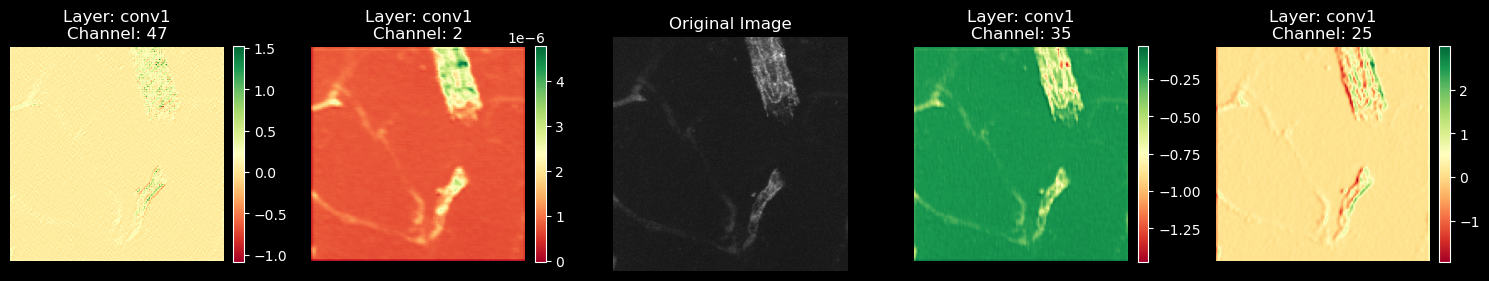

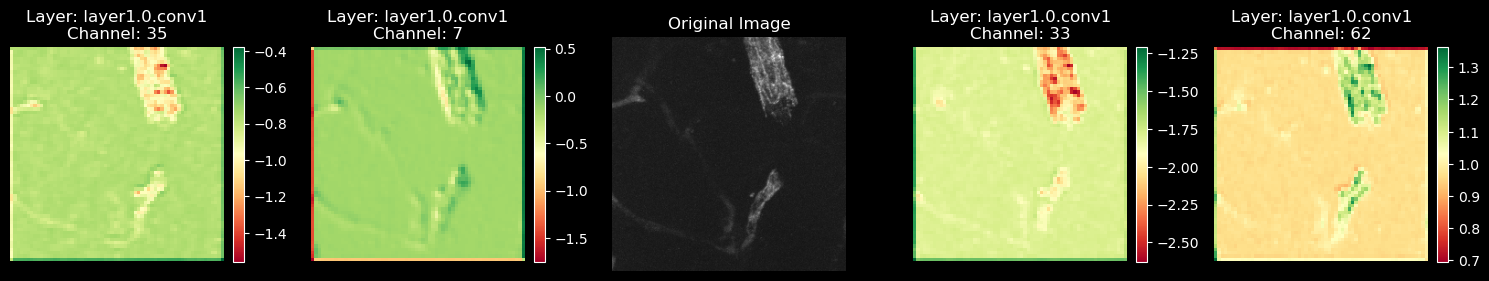

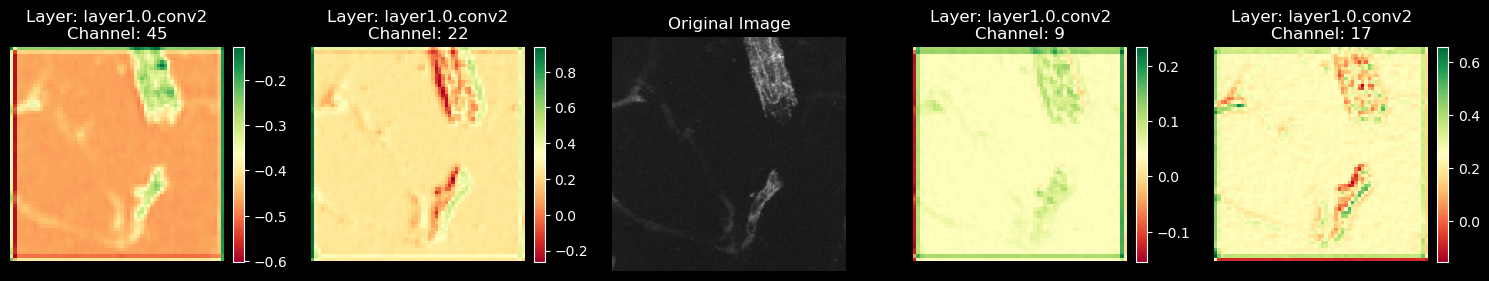

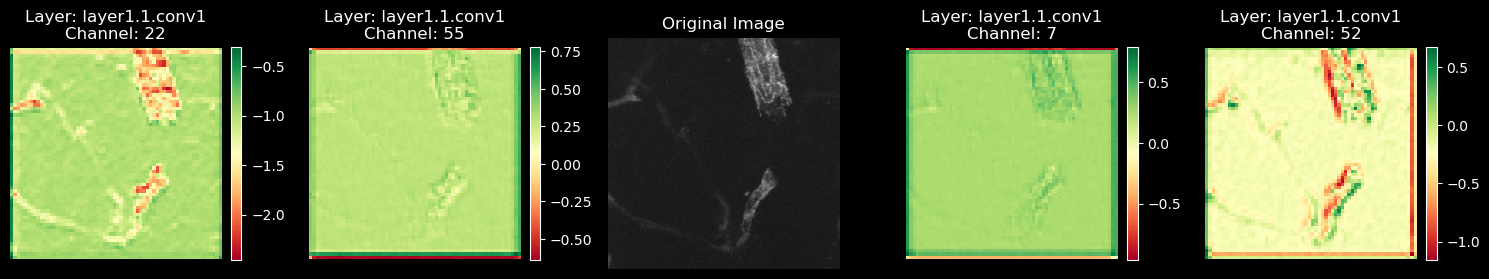

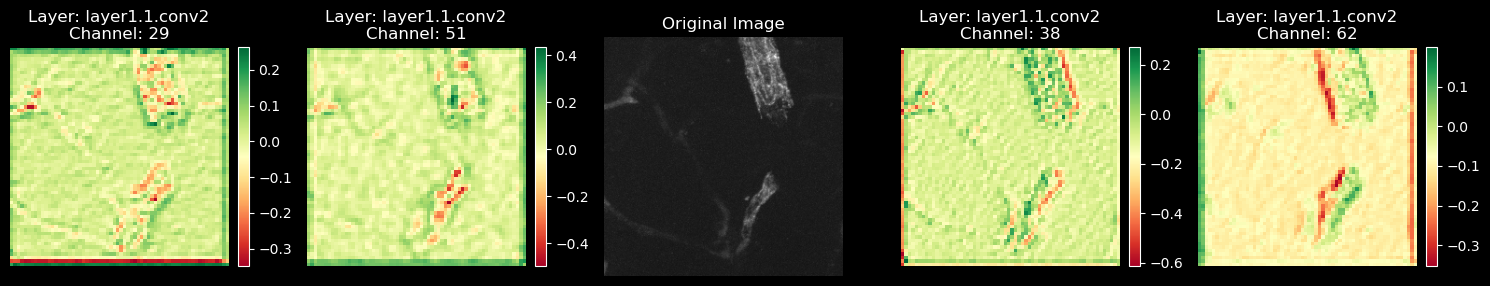

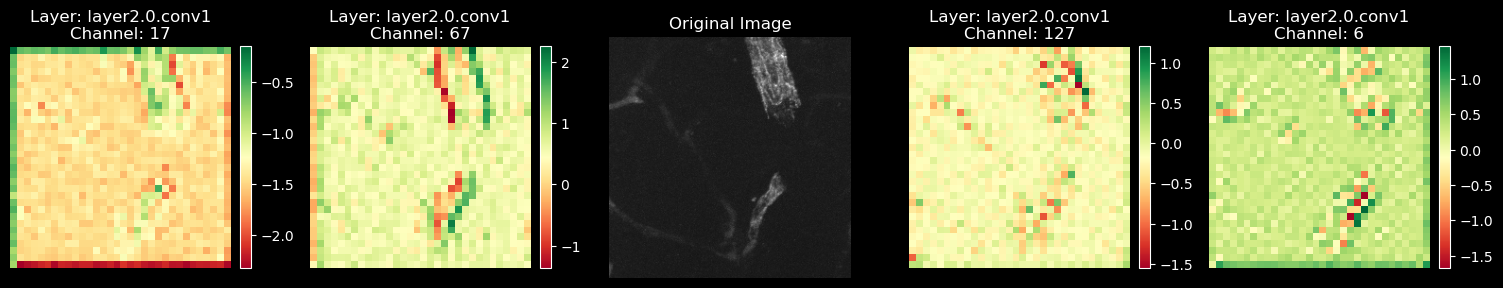

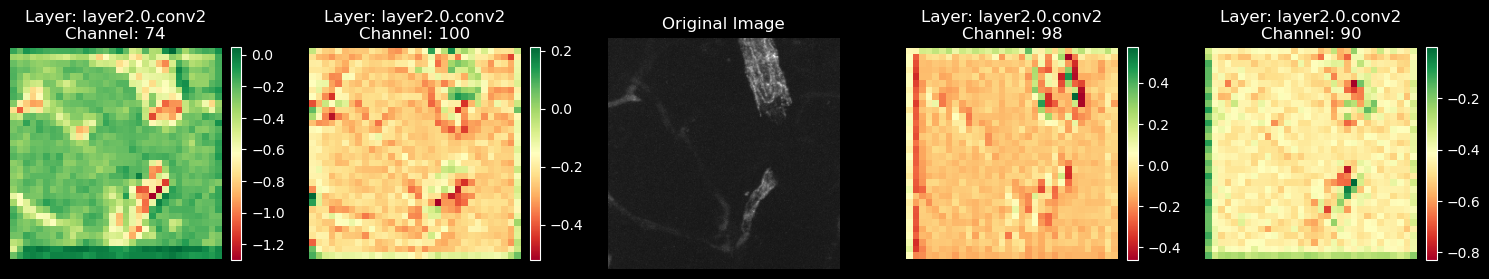

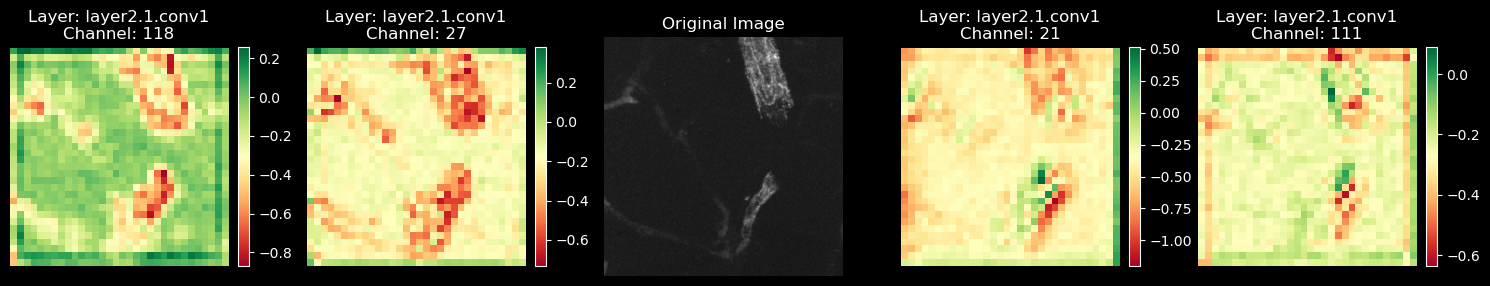

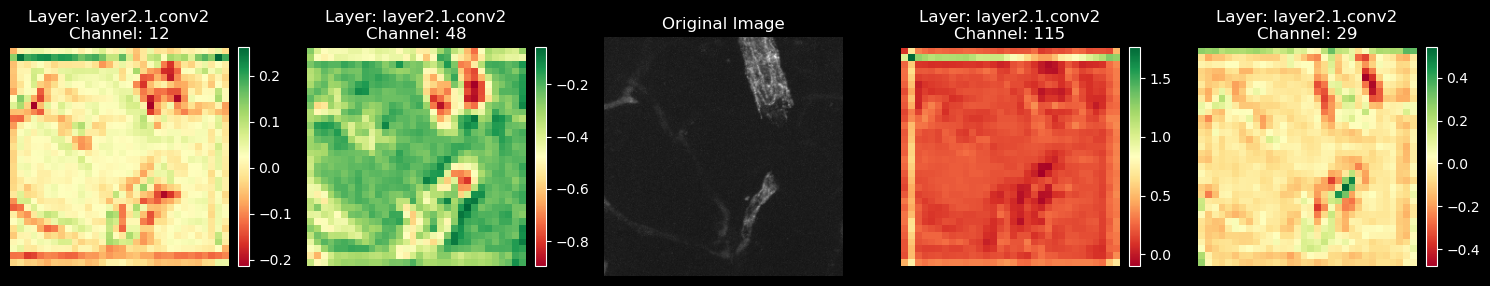

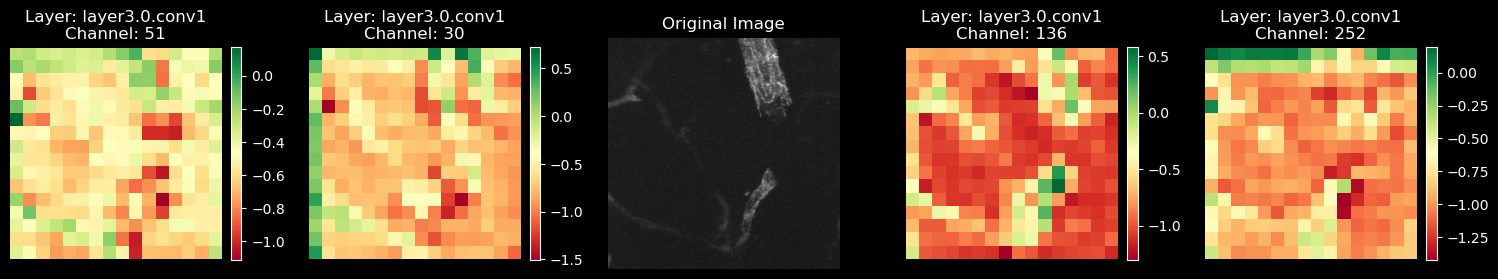

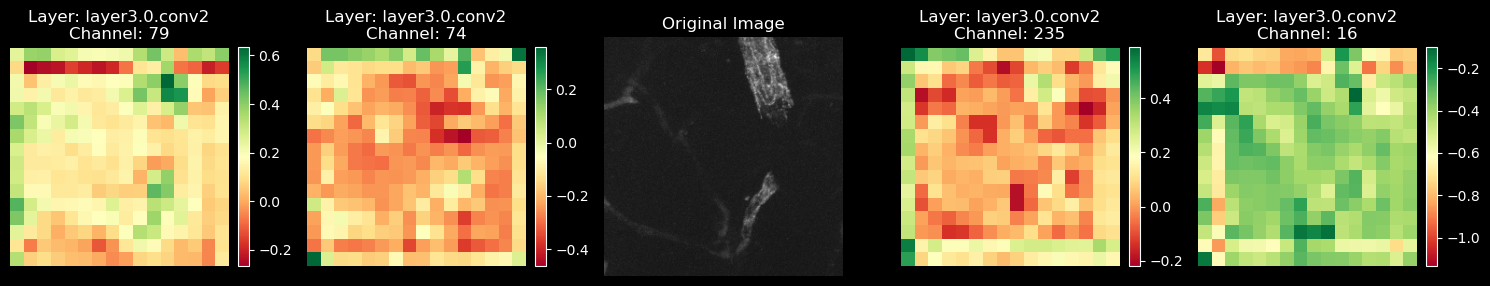

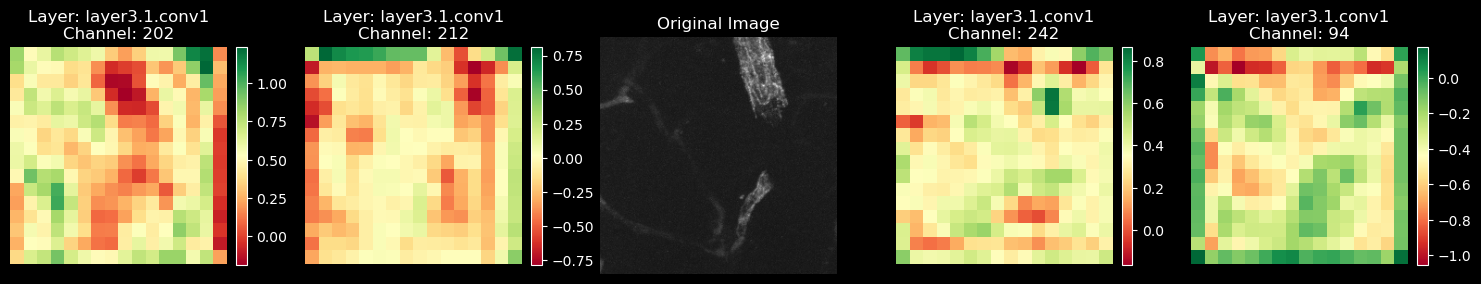

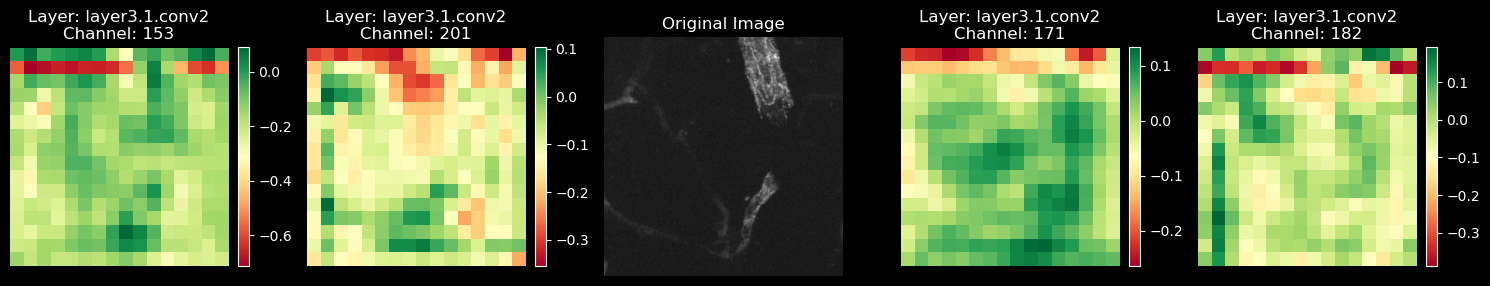

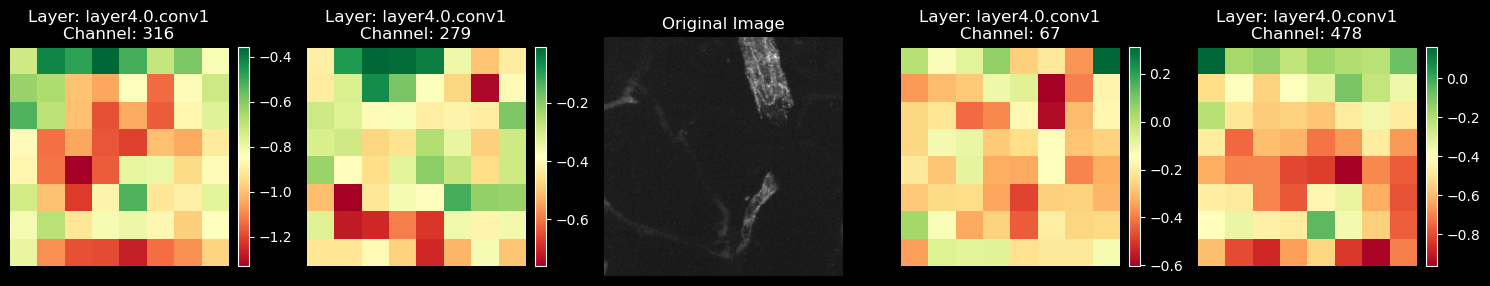

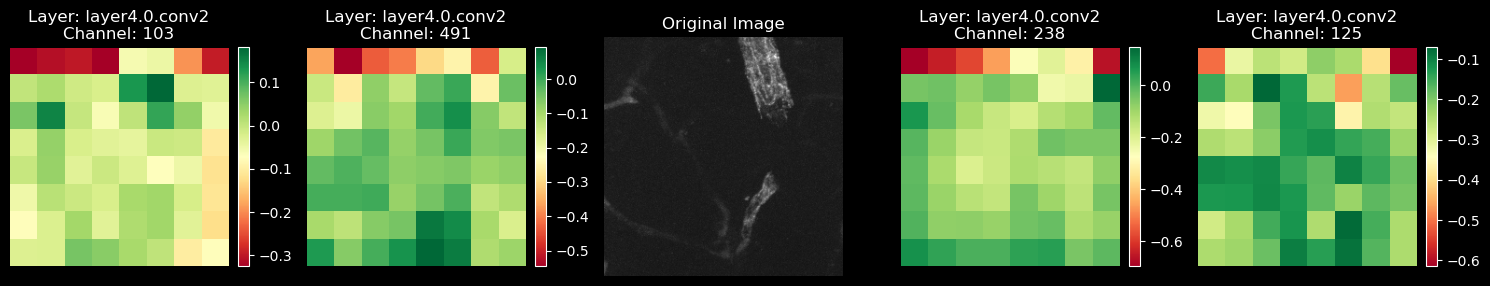

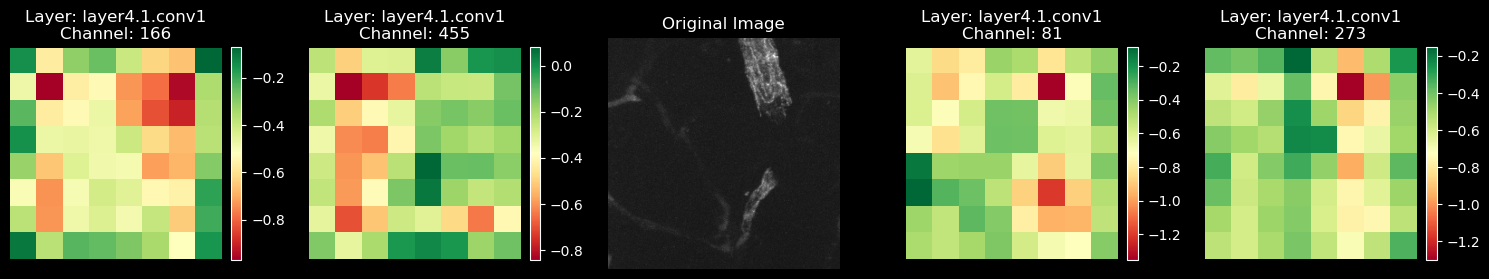

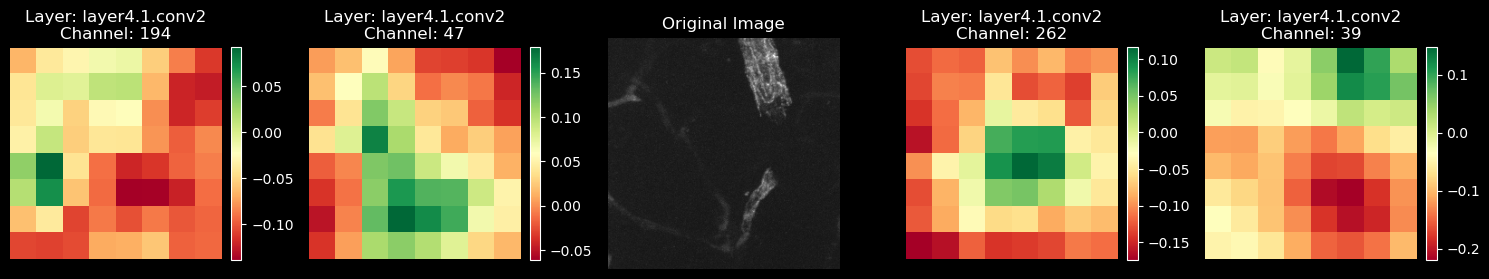

In [27]:
plot_activations(activations, img, num_activations=5, layer_types=['conv'])

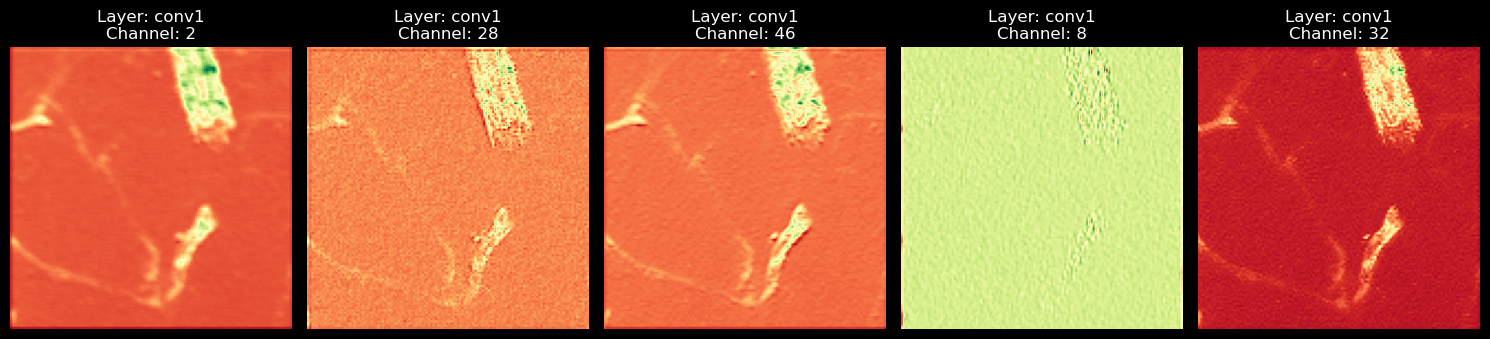

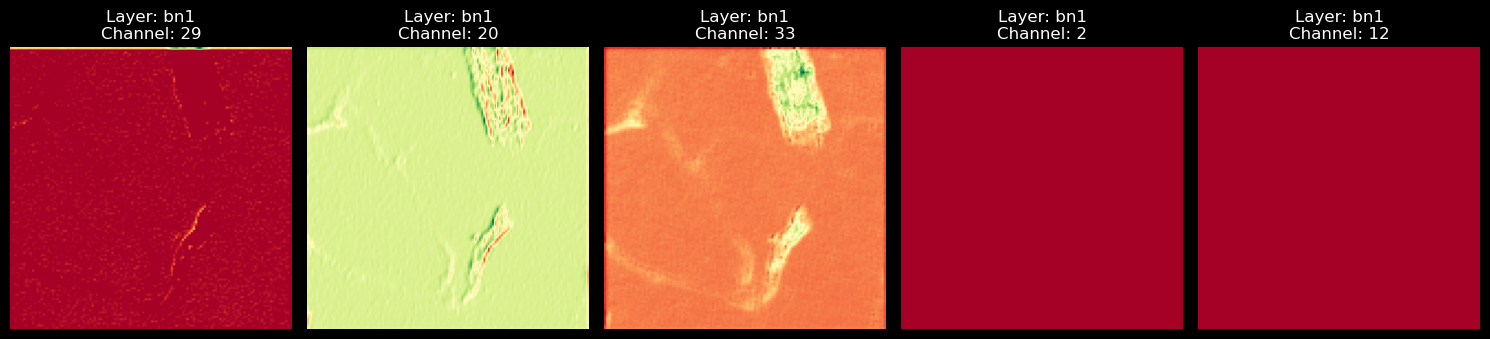

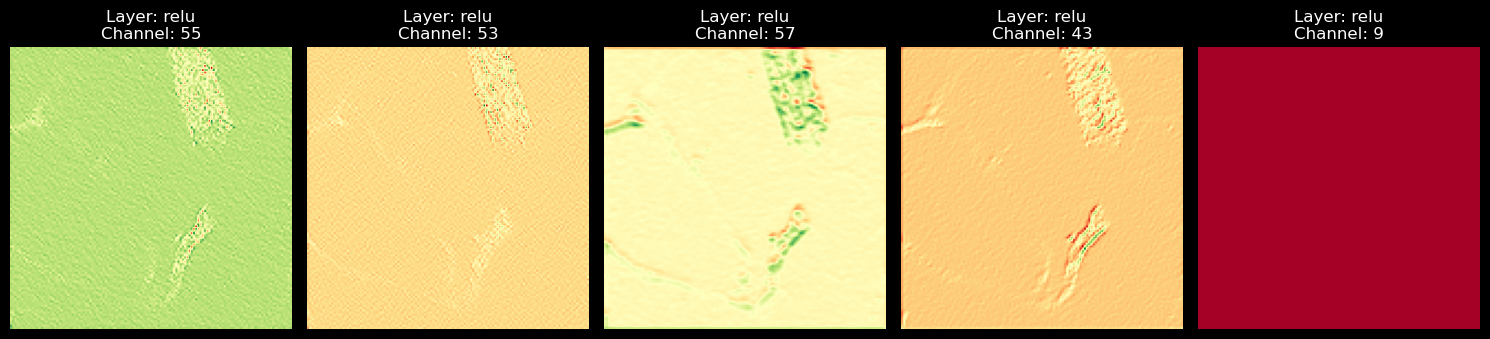

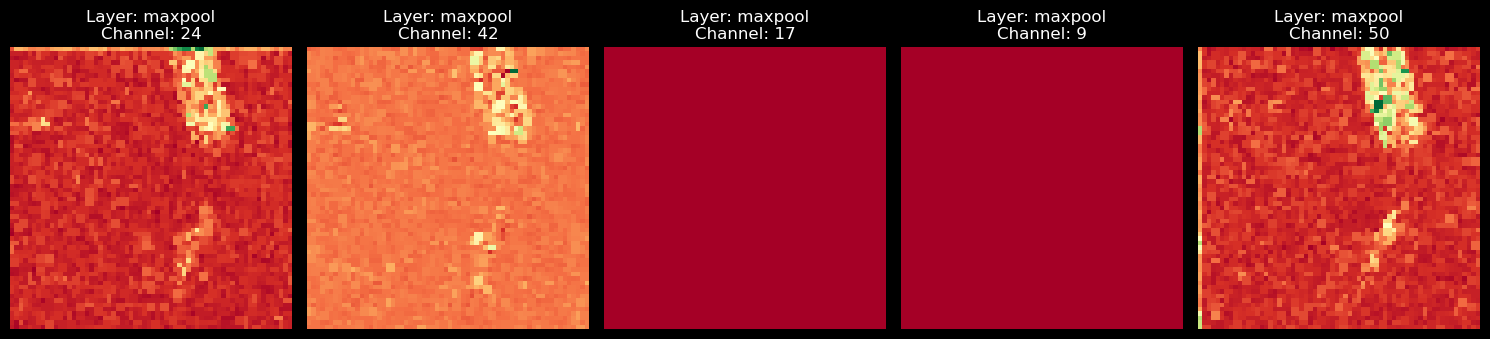

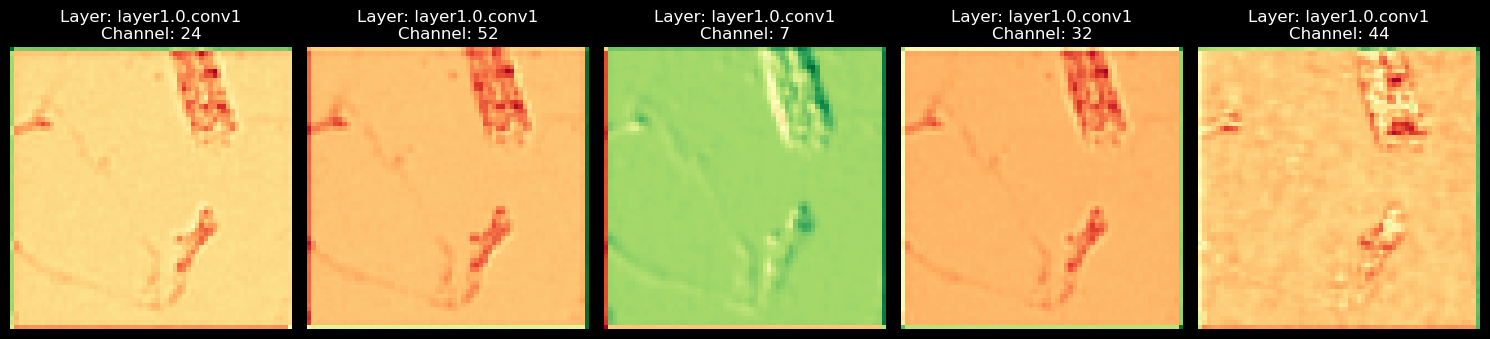

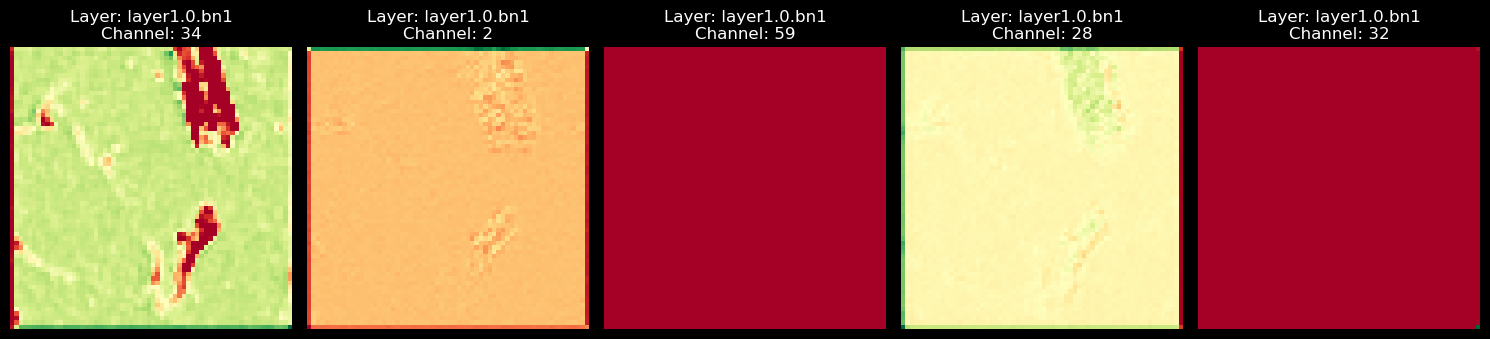

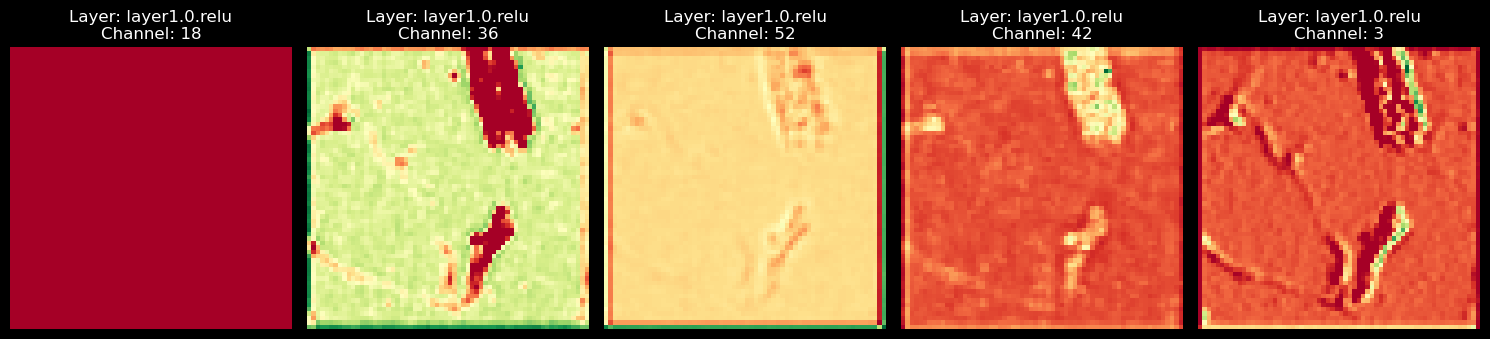

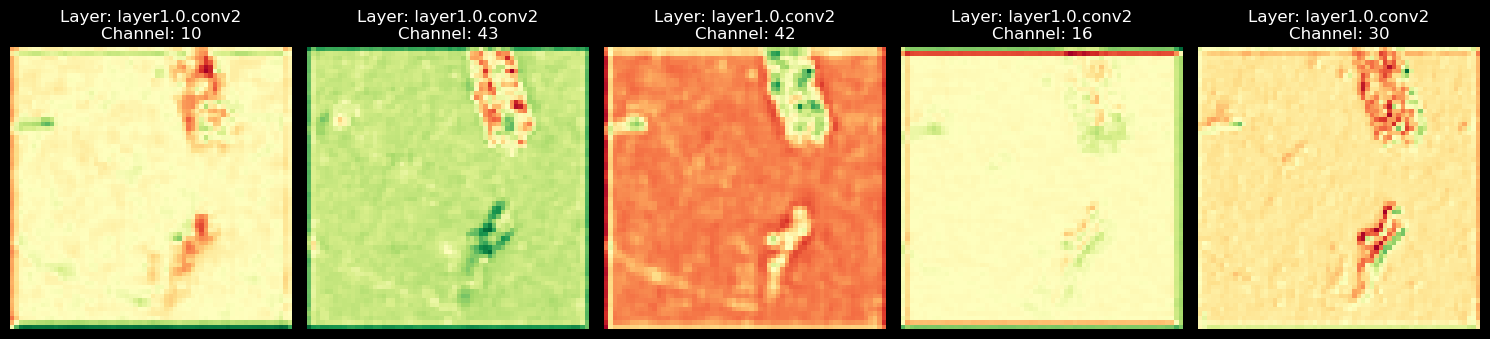

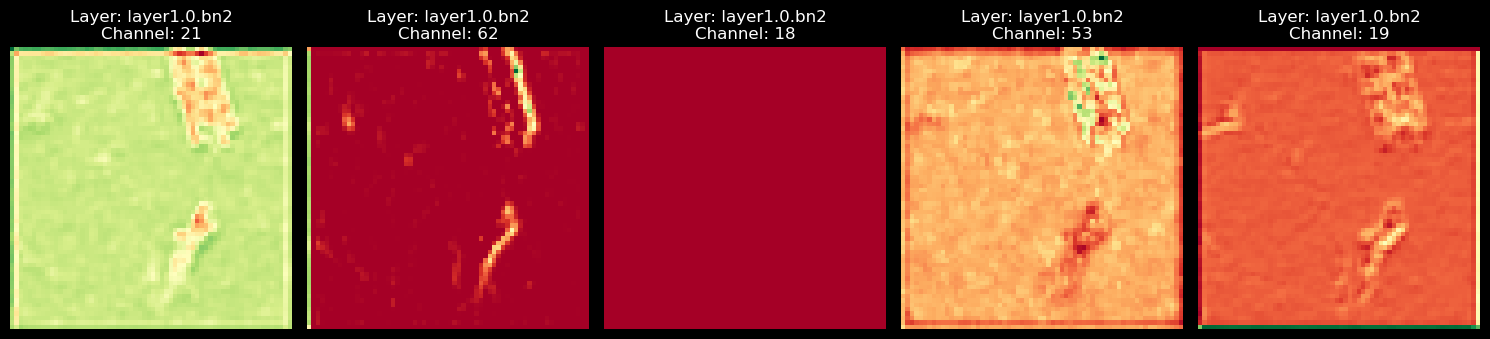

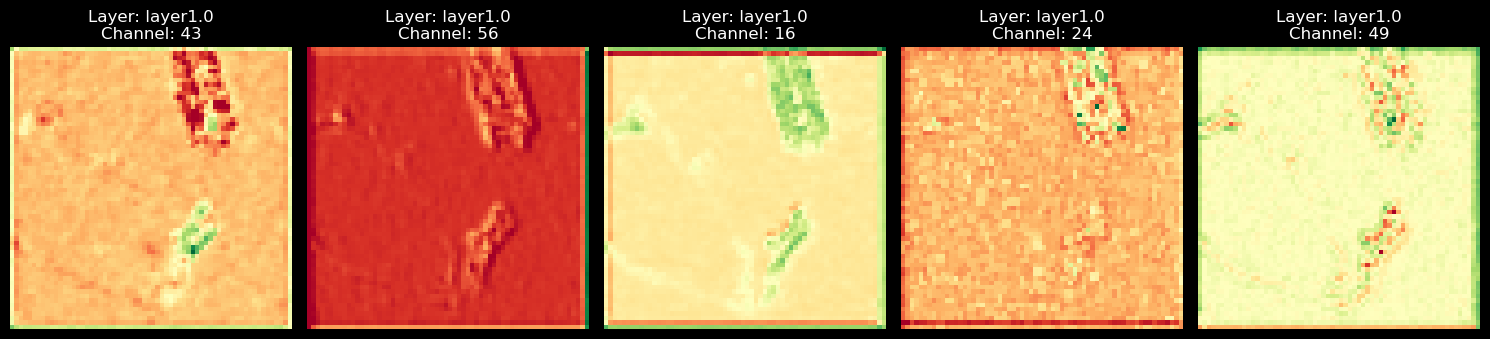

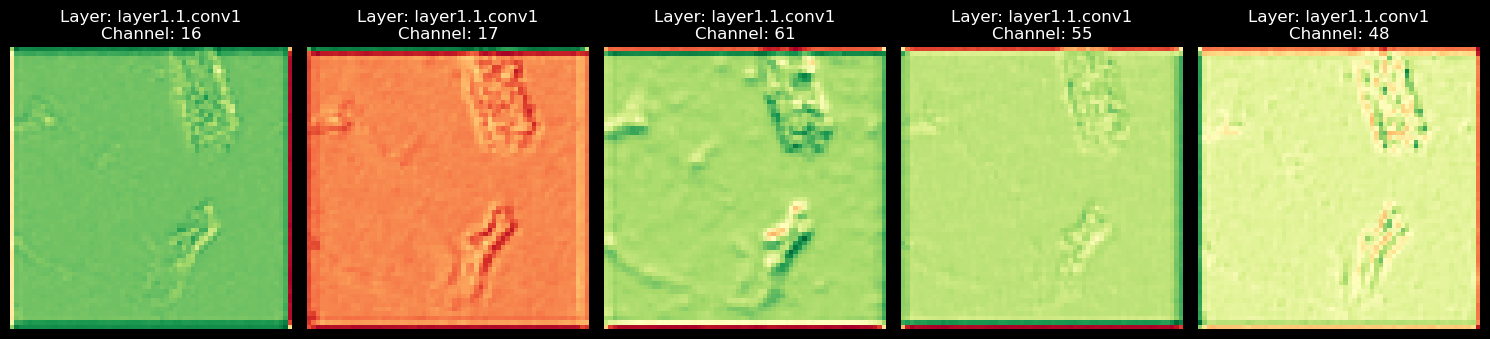

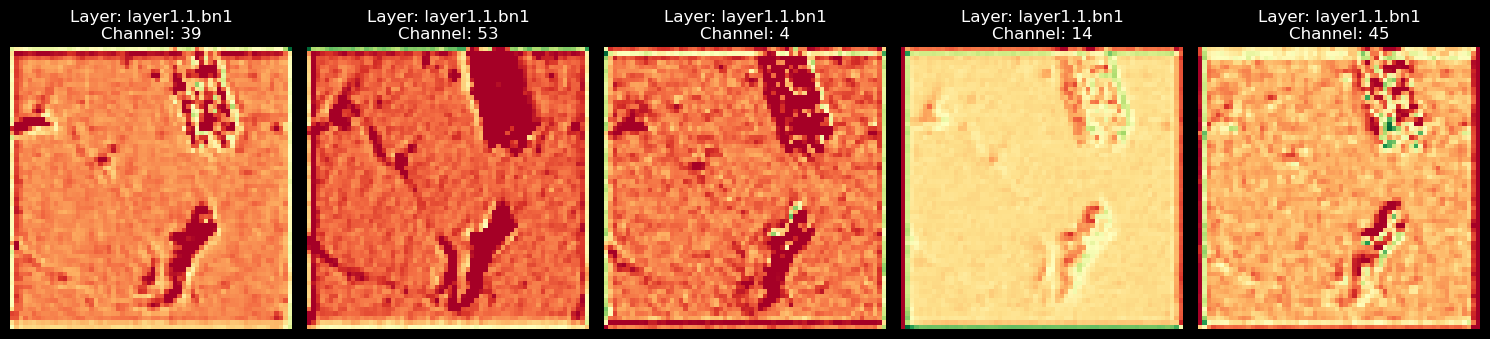

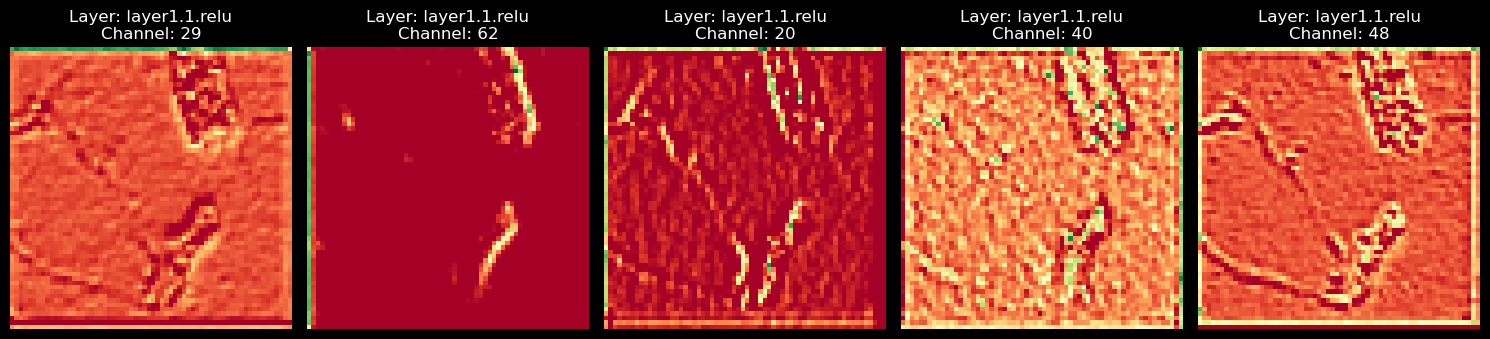

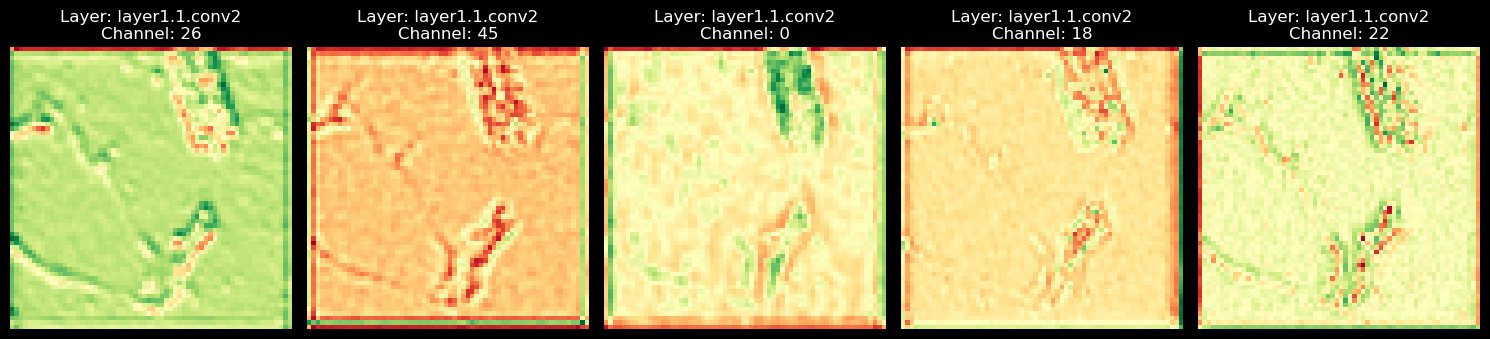

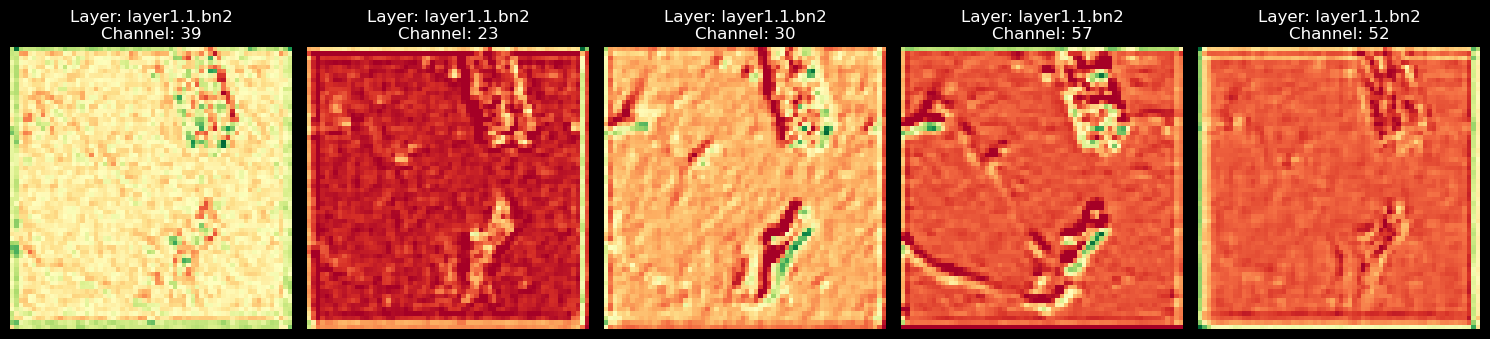

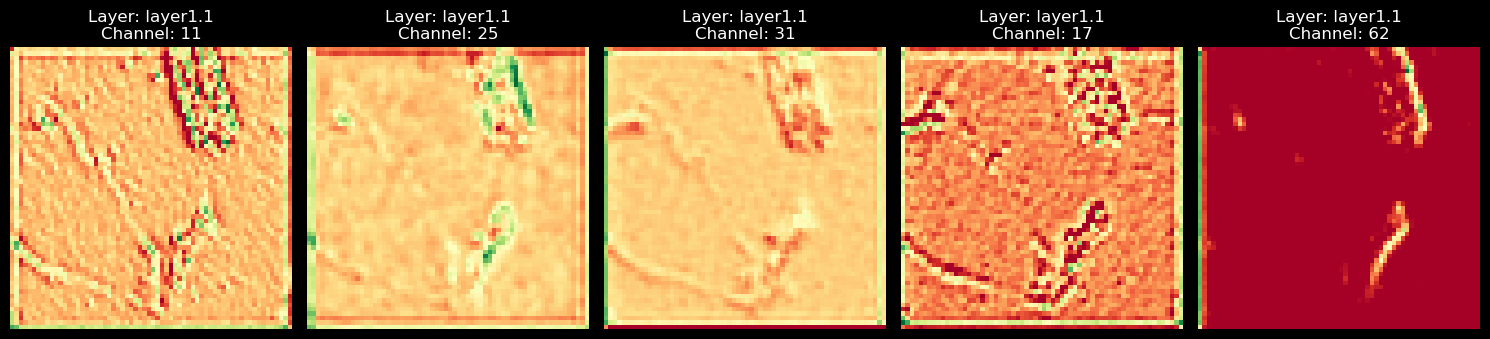

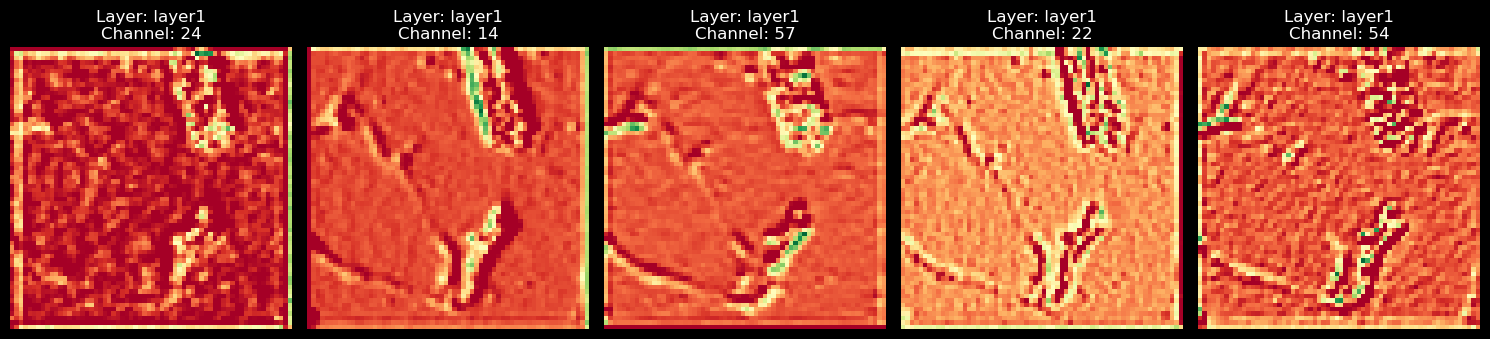

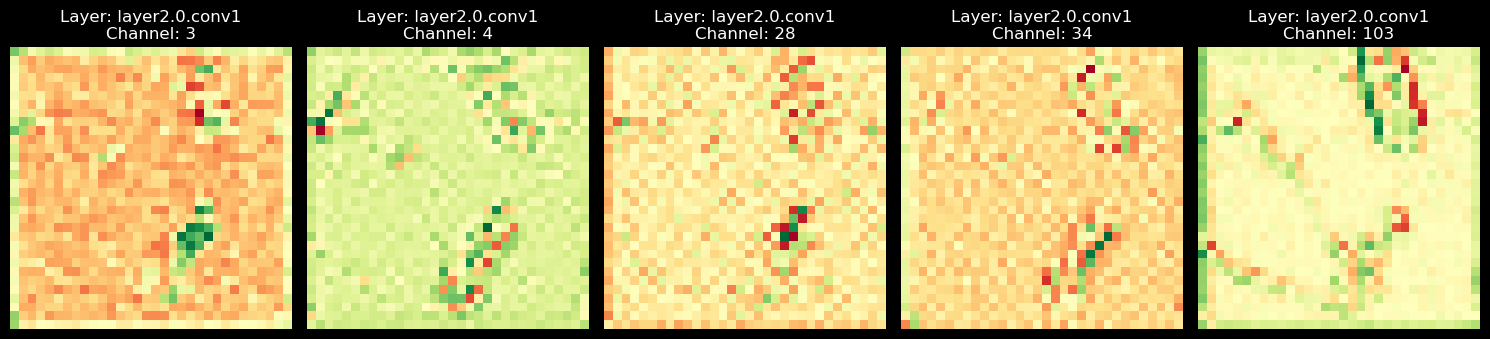

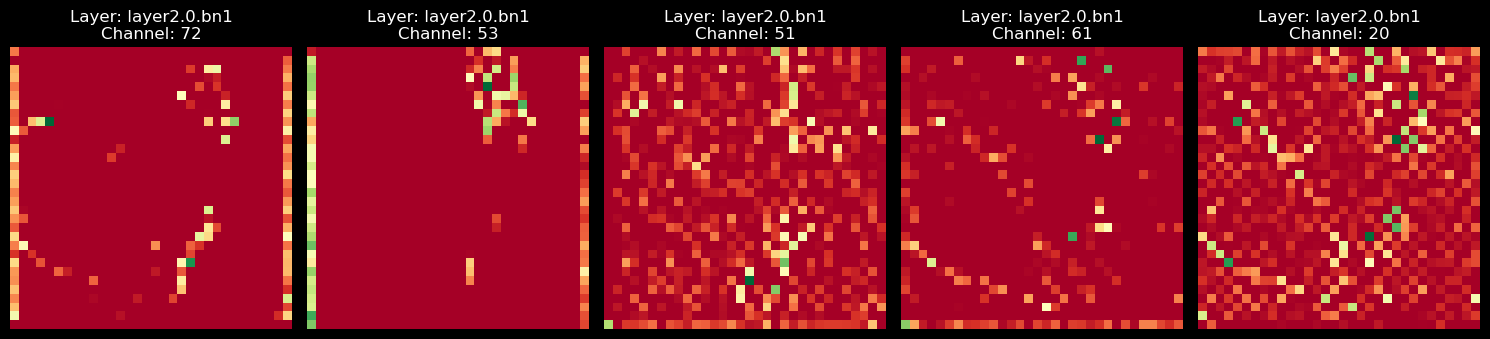

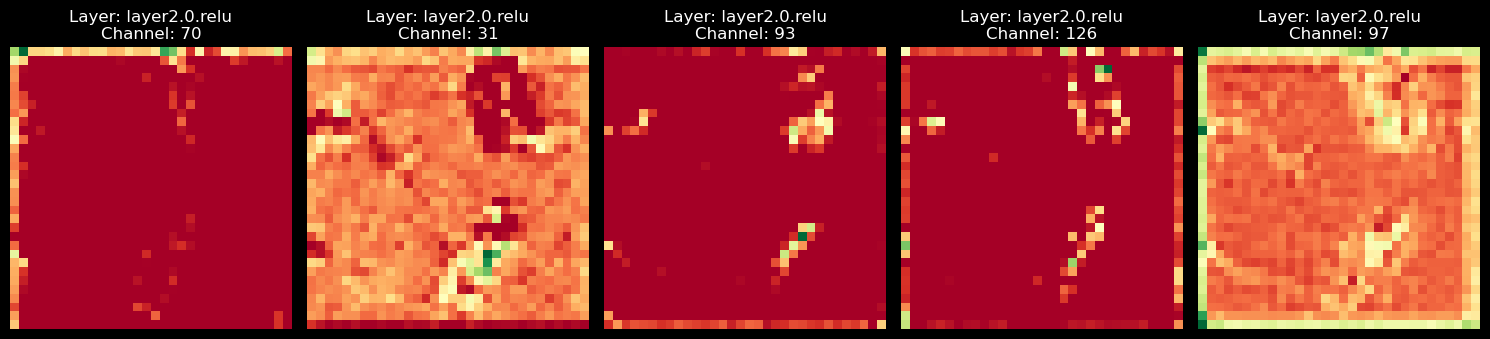

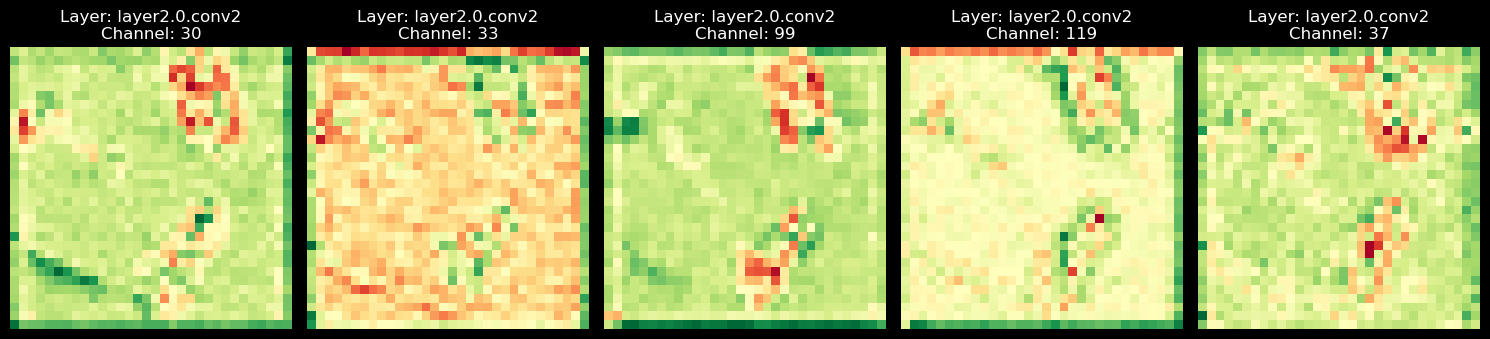

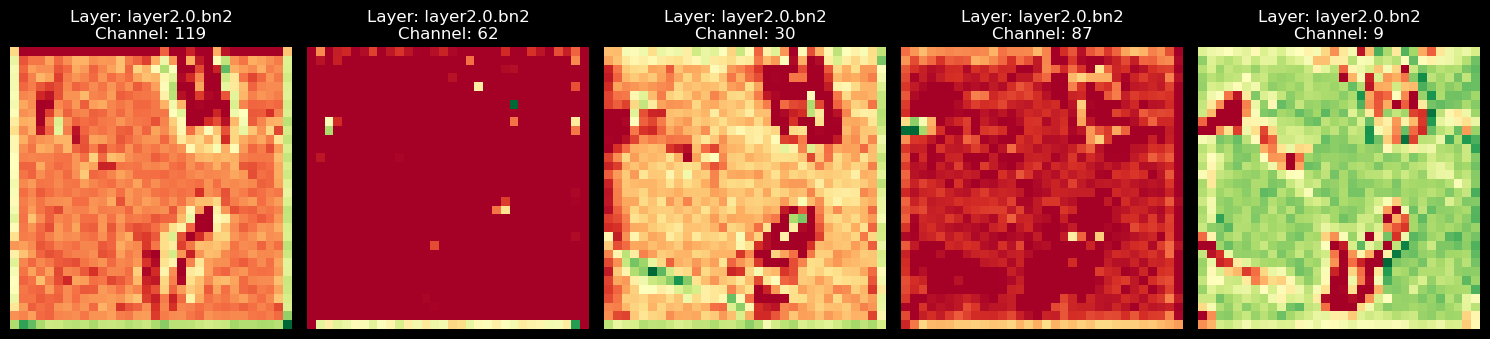

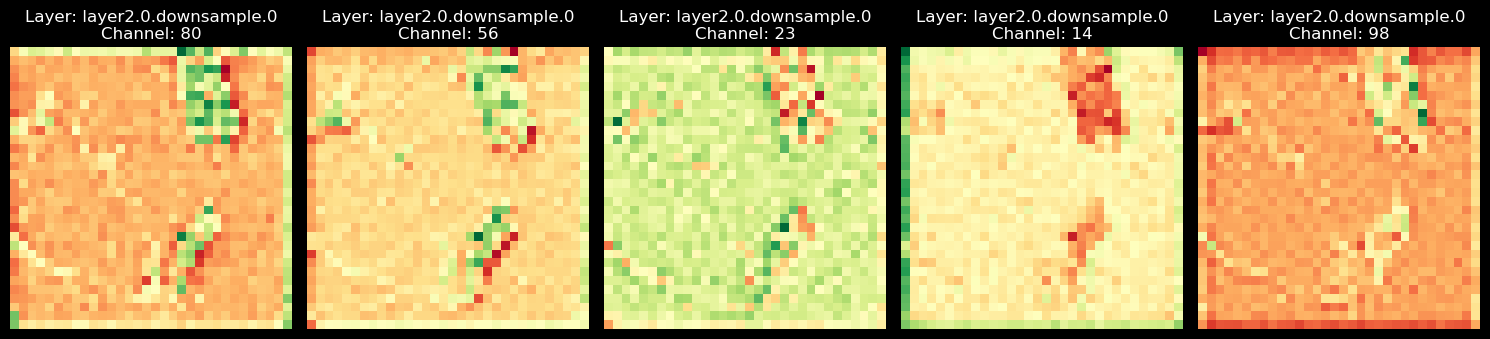

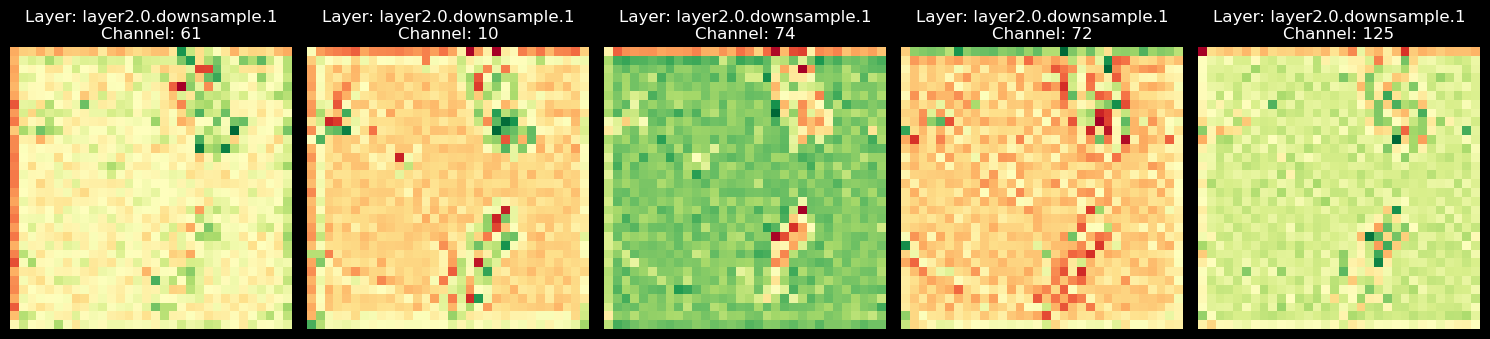

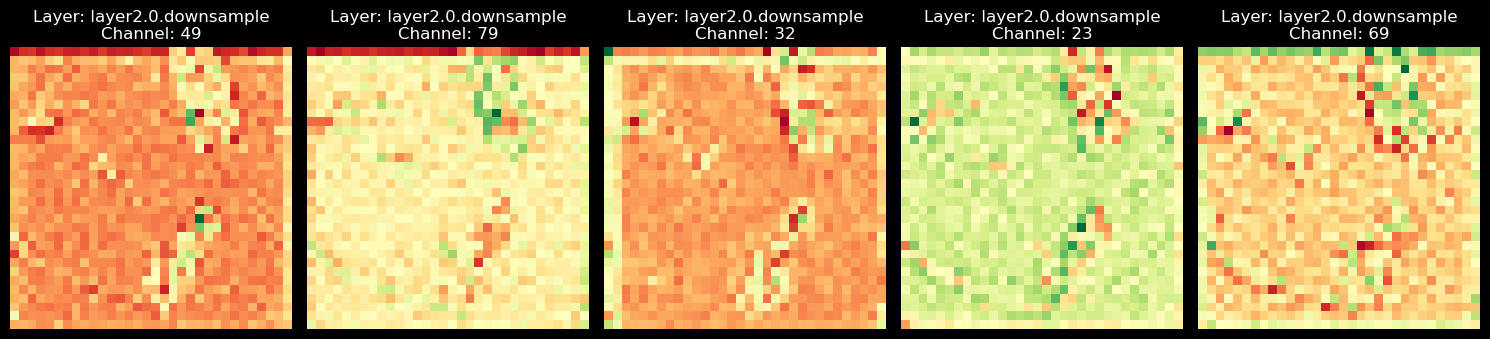

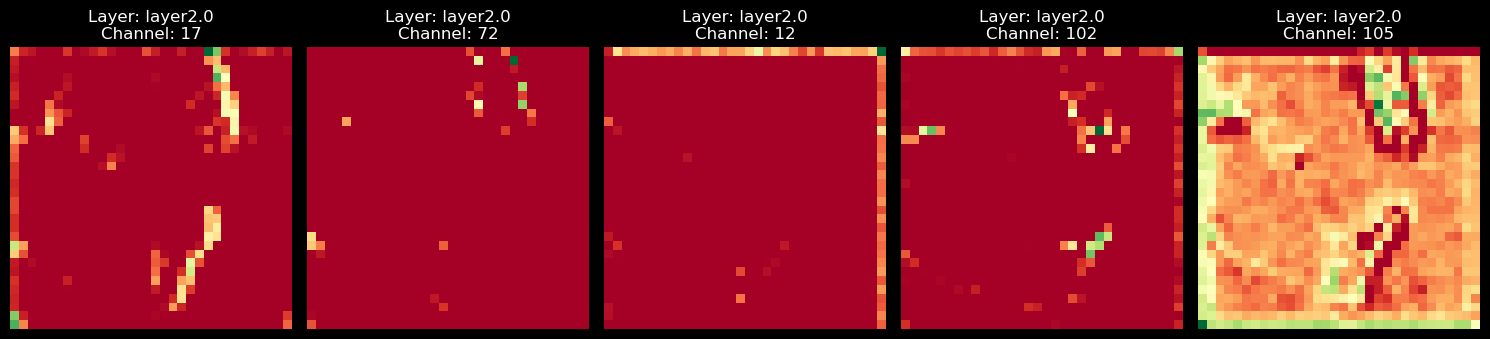

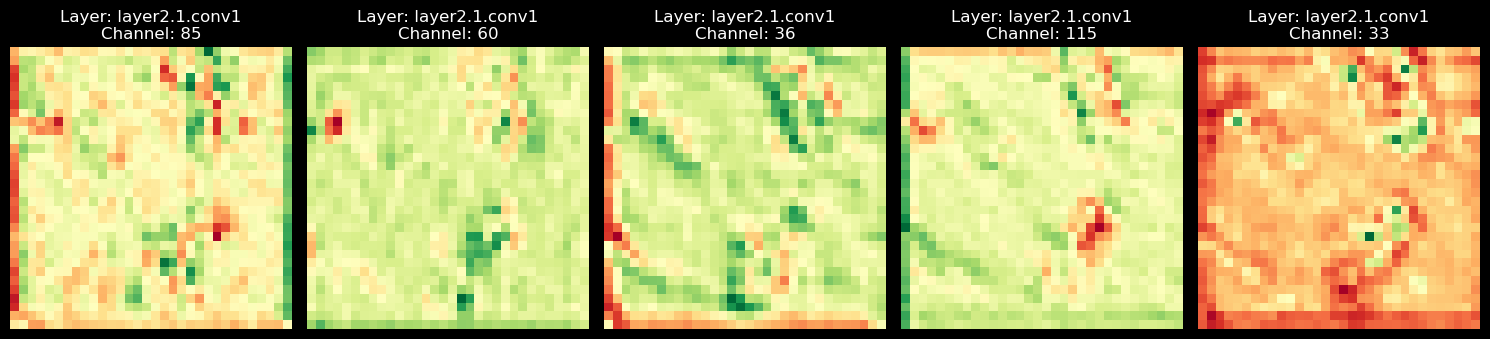

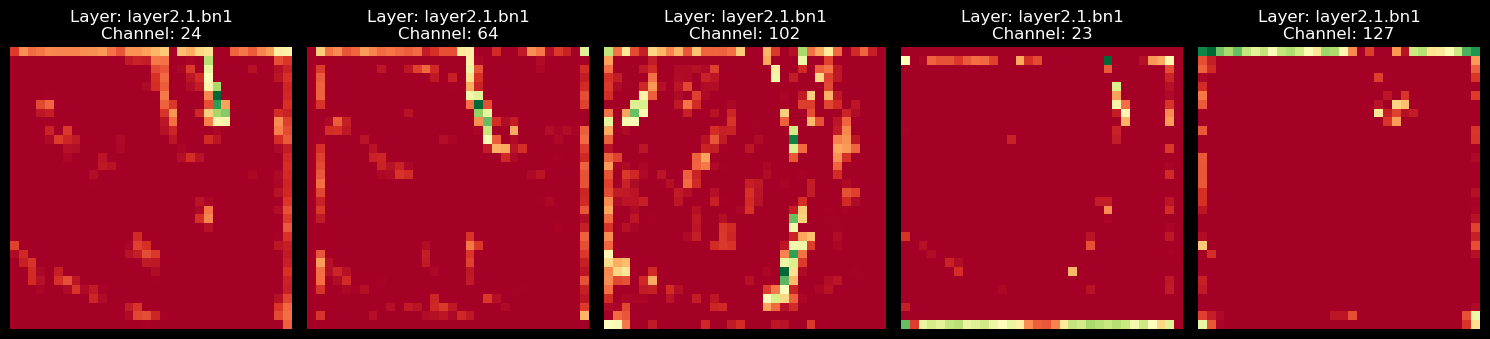

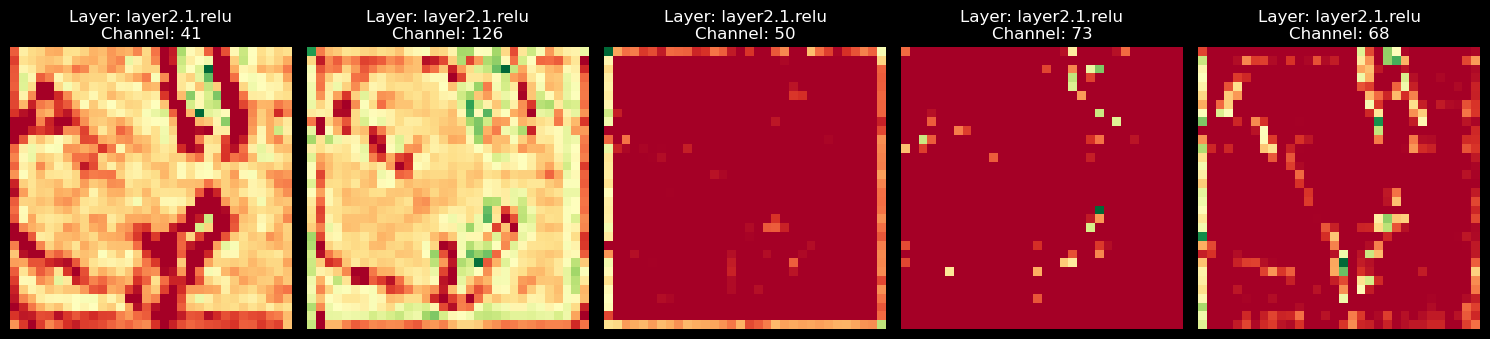

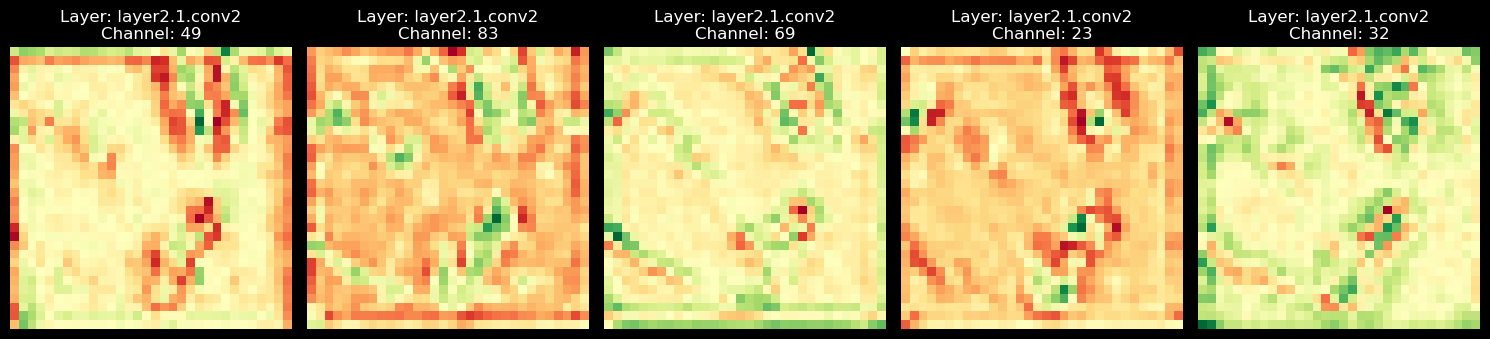

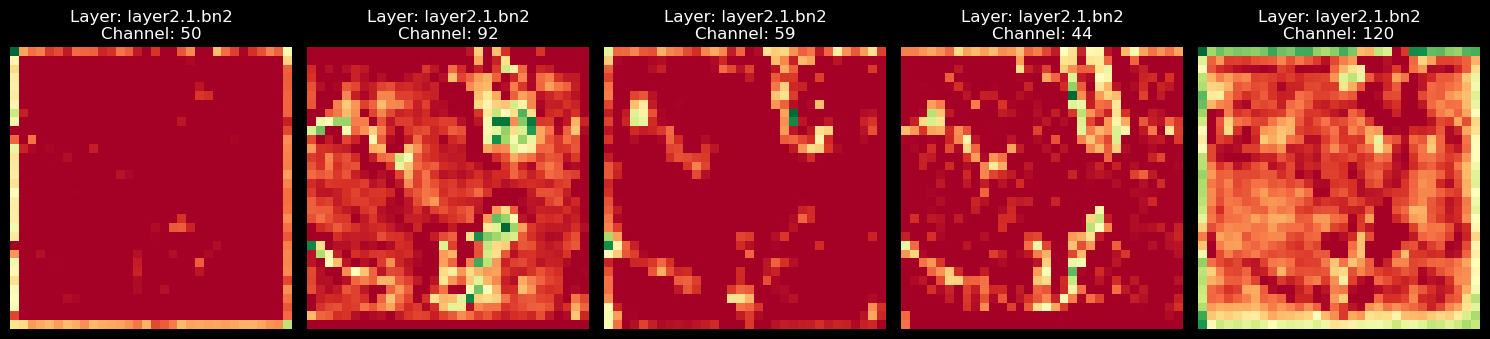

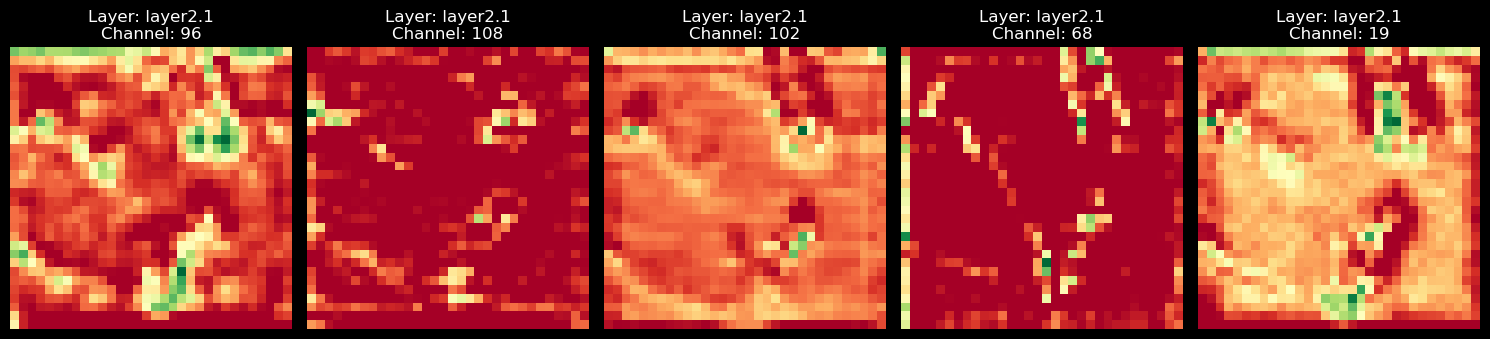

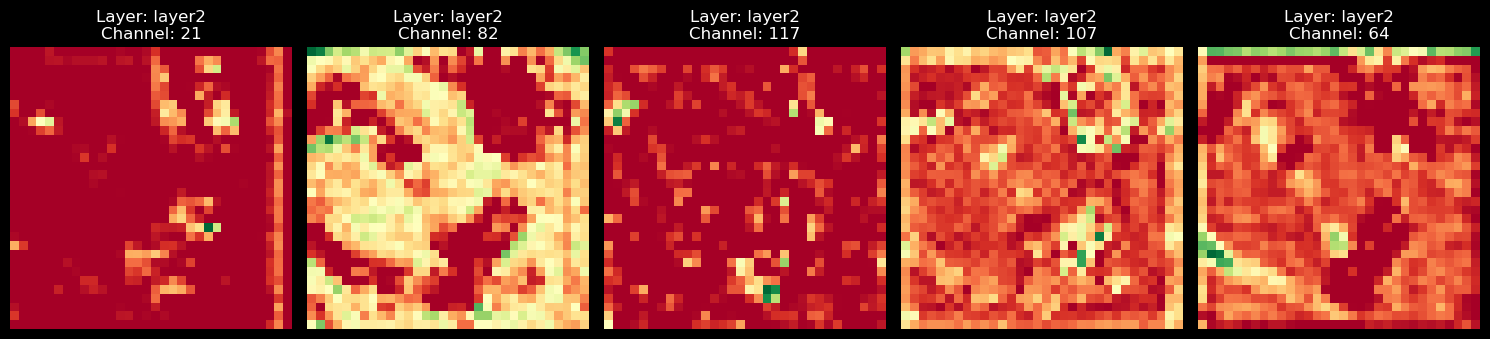

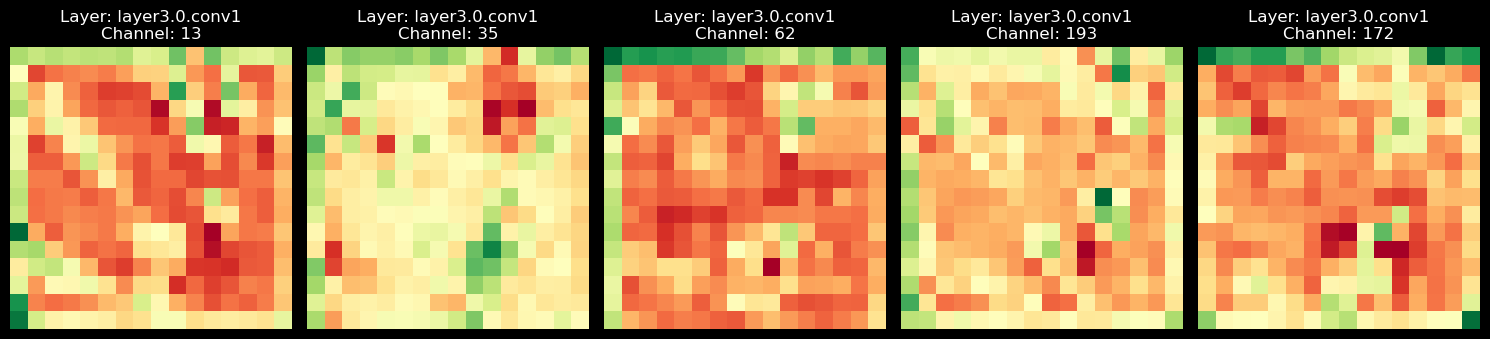

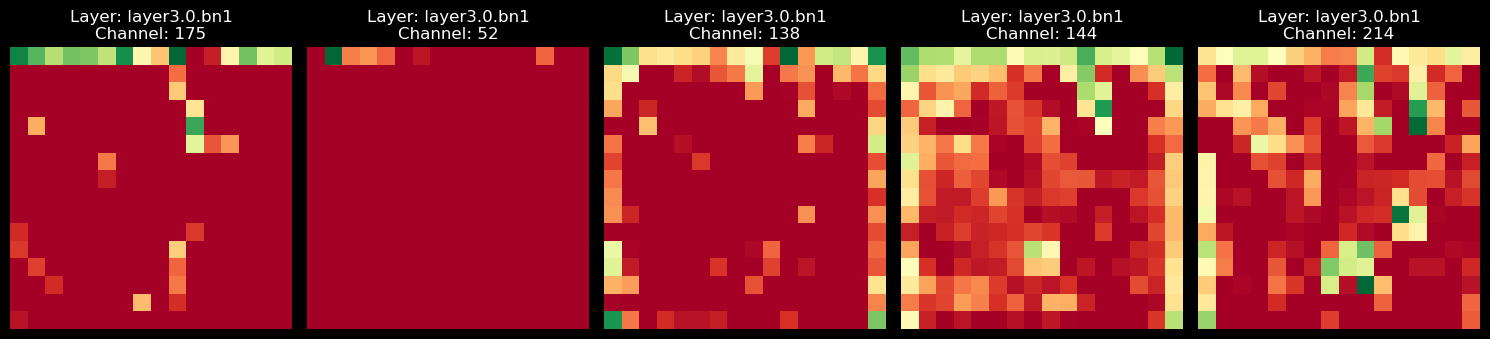

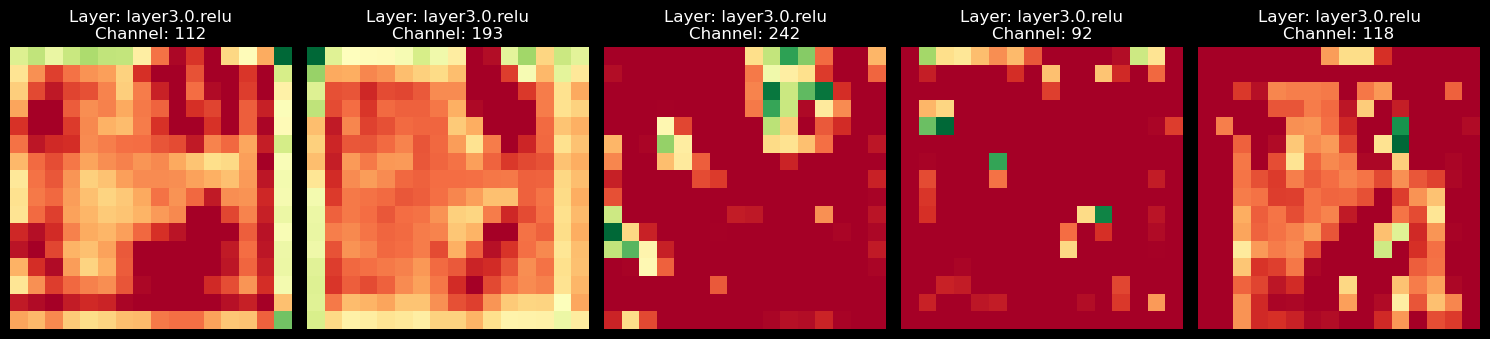

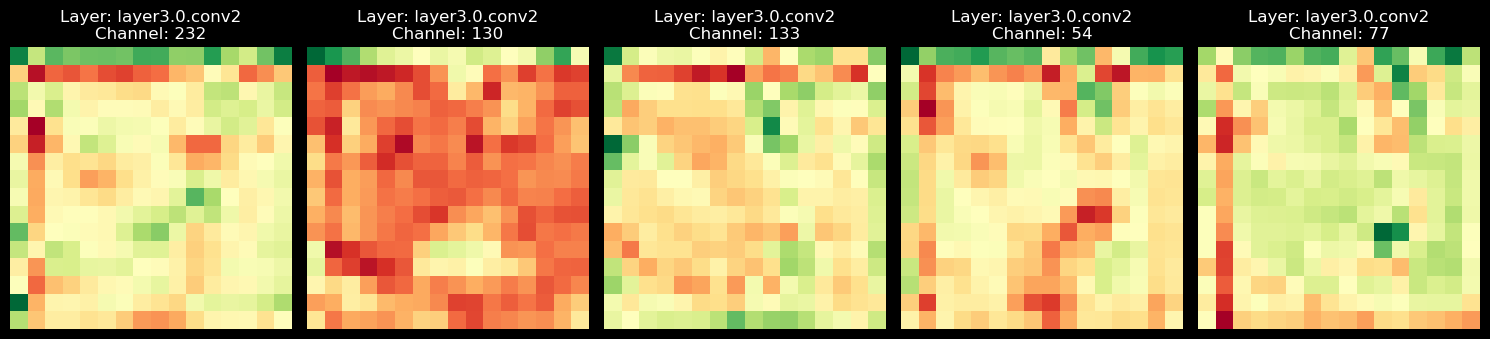

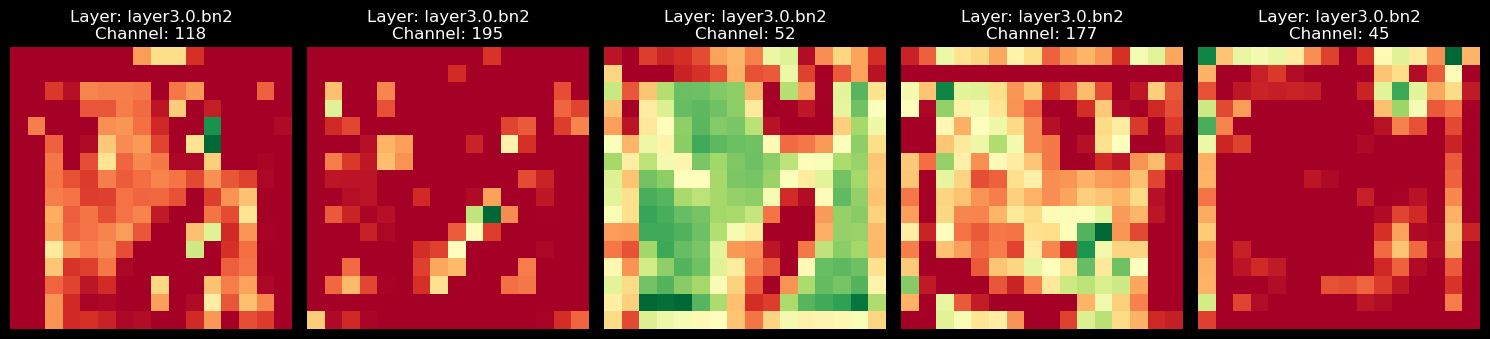

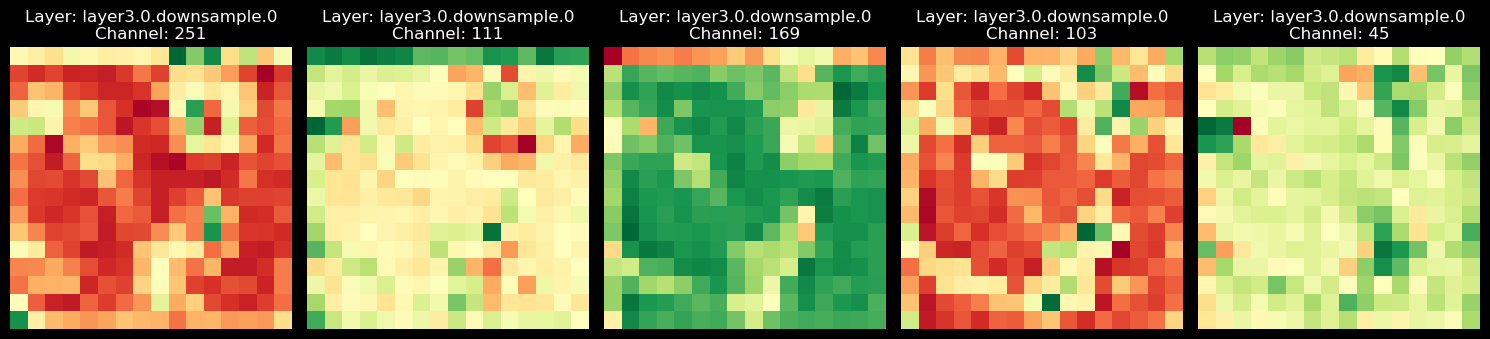

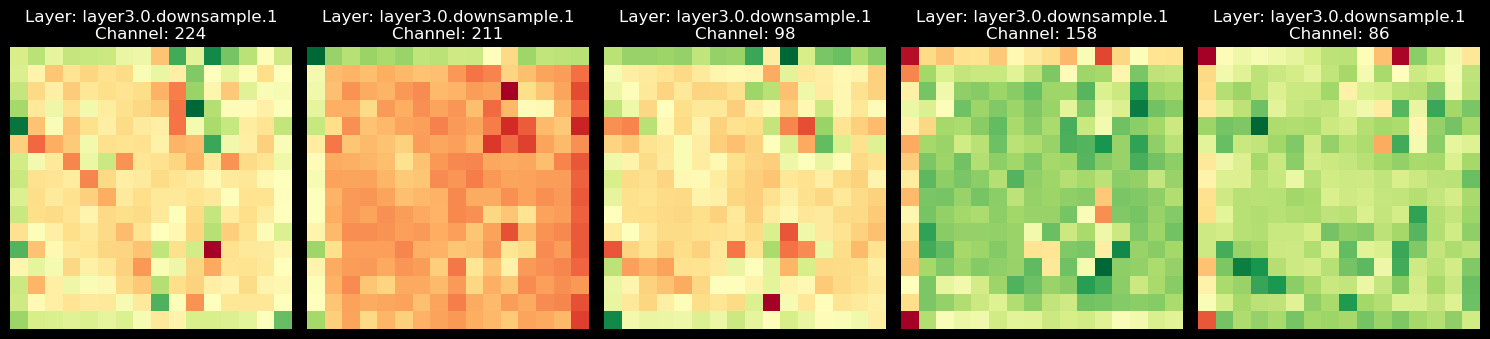

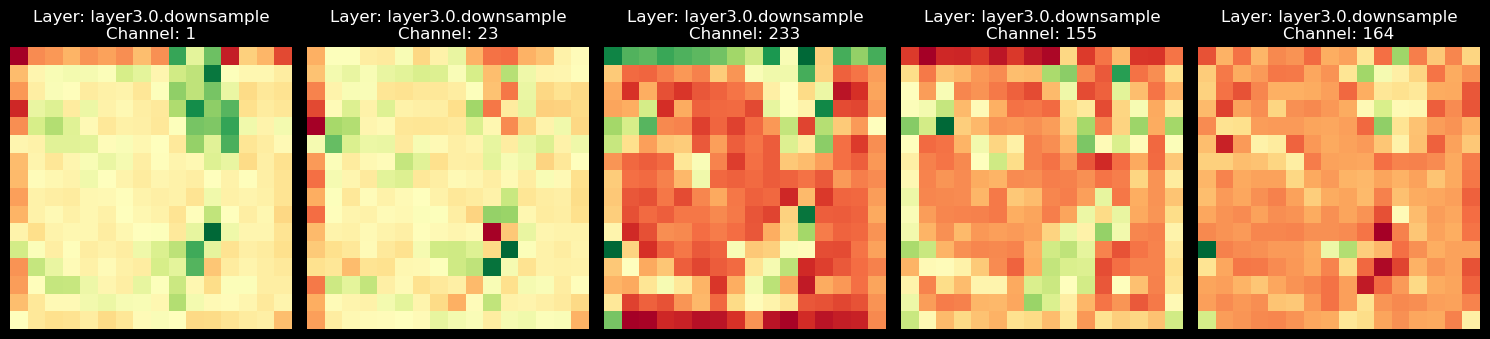

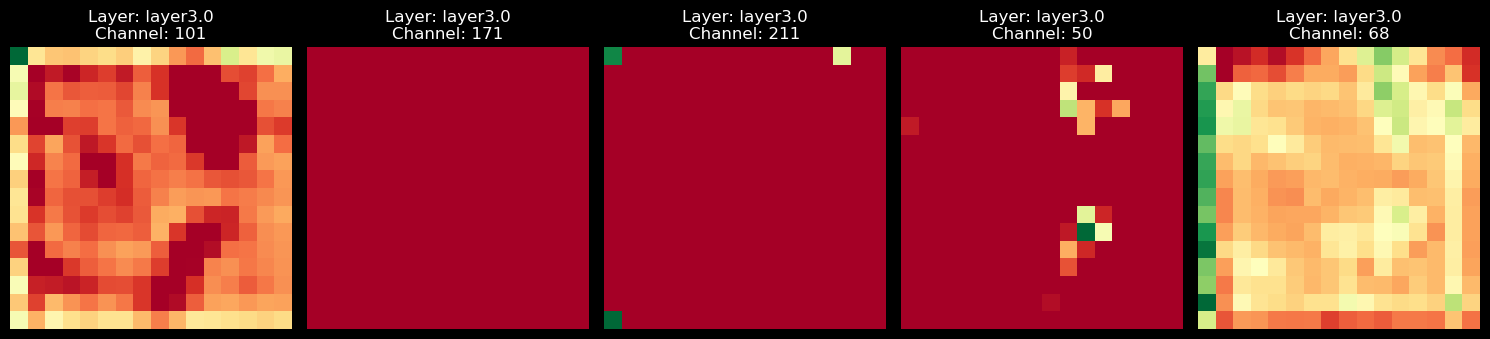

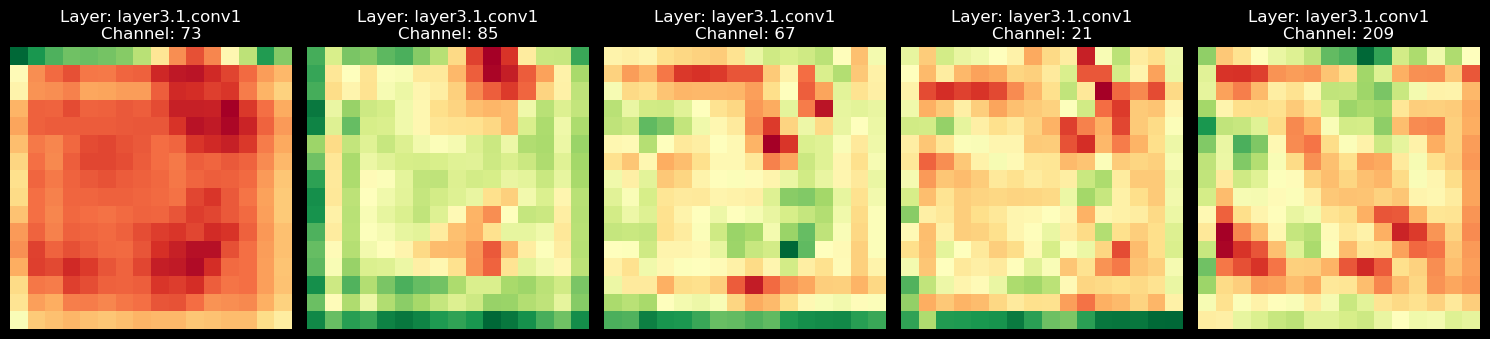

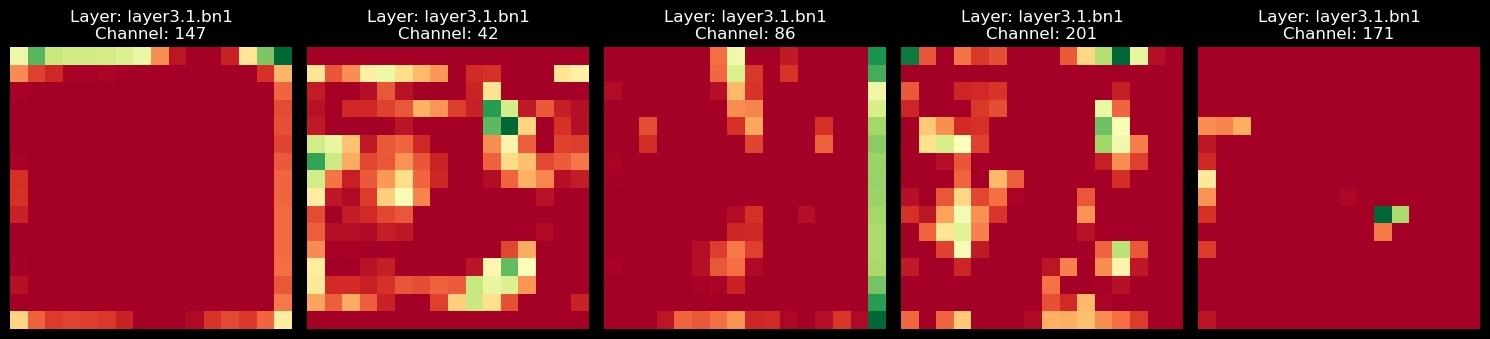

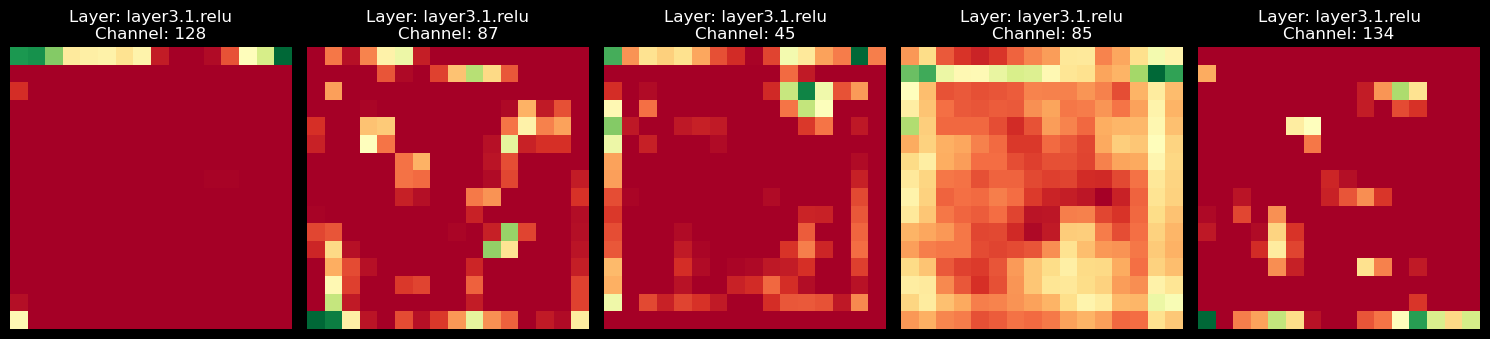

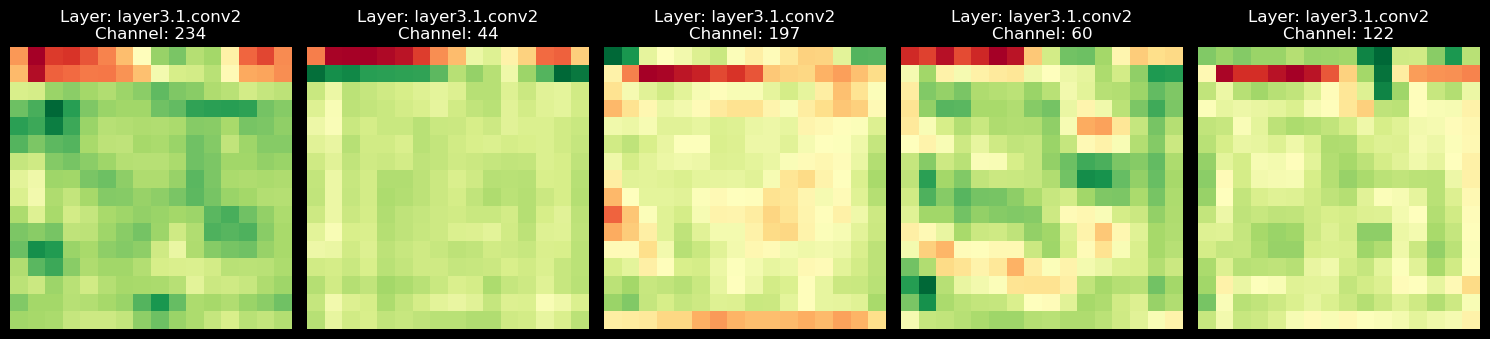

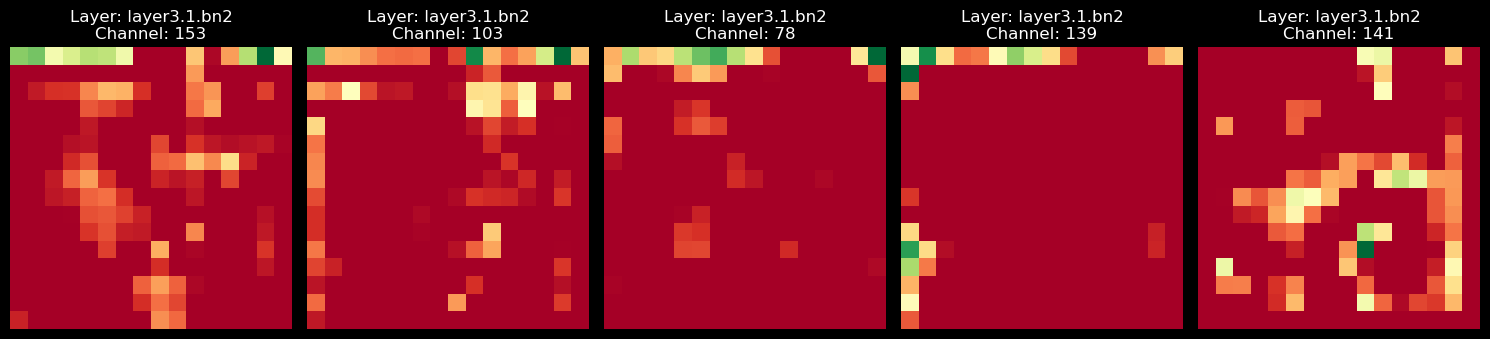

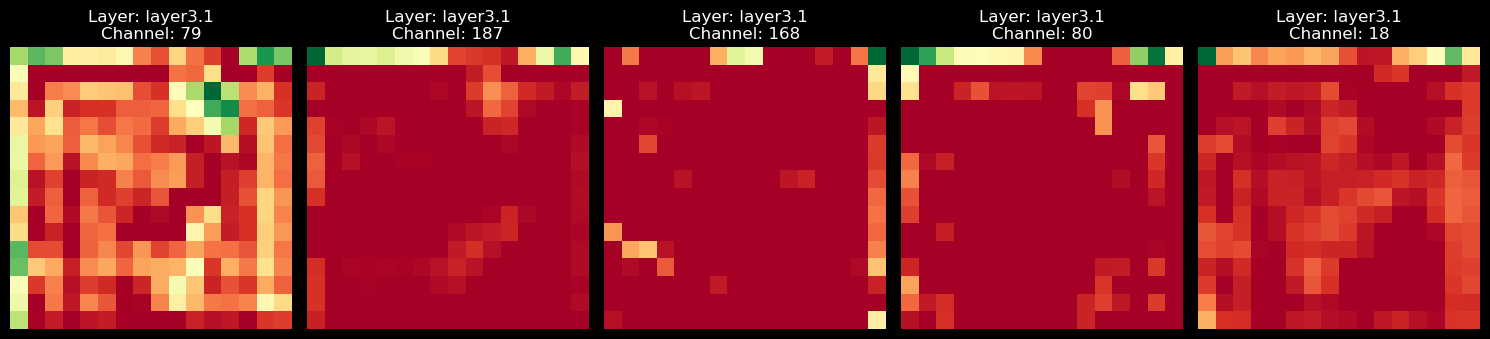

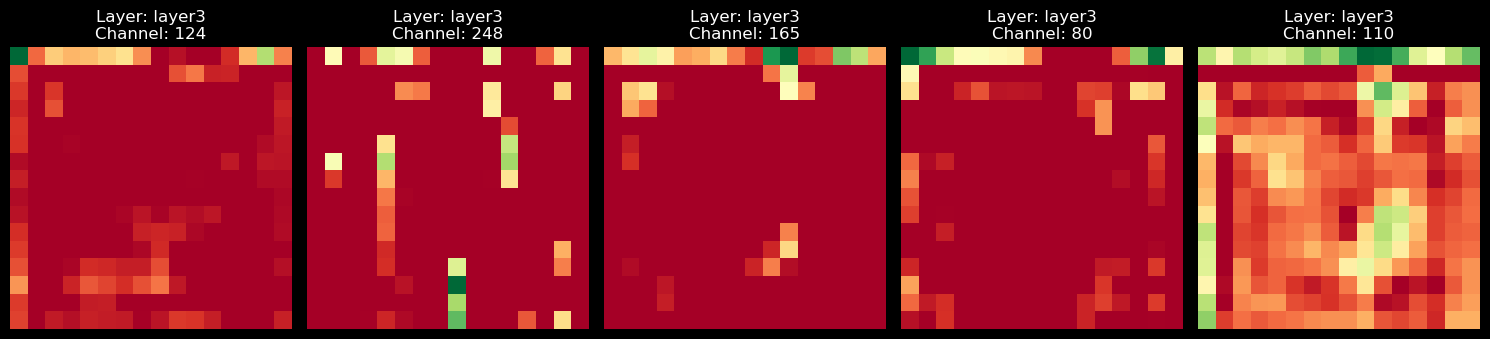

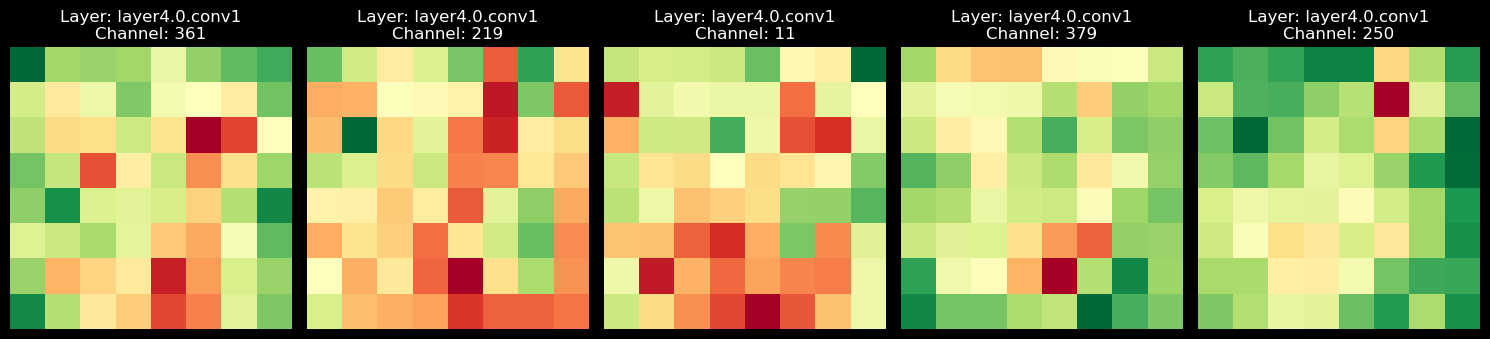

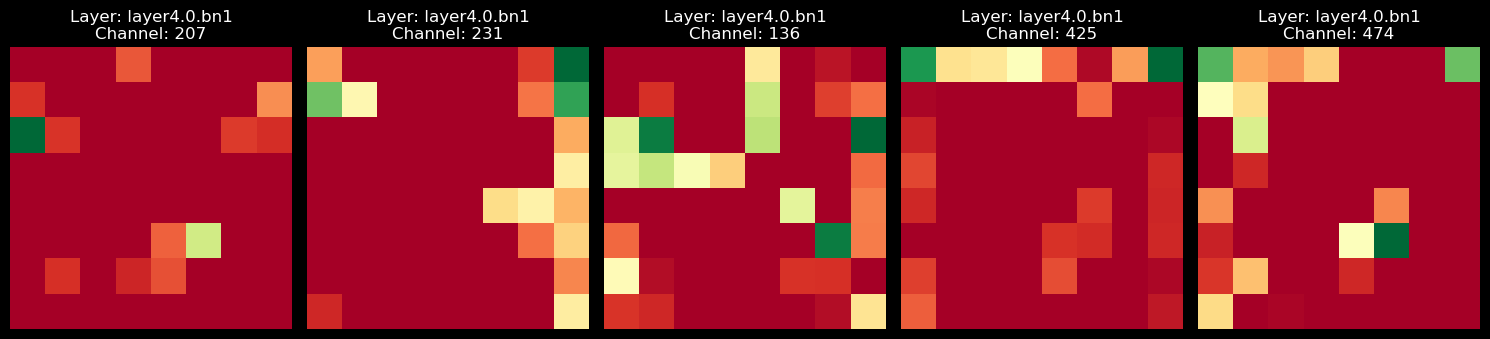

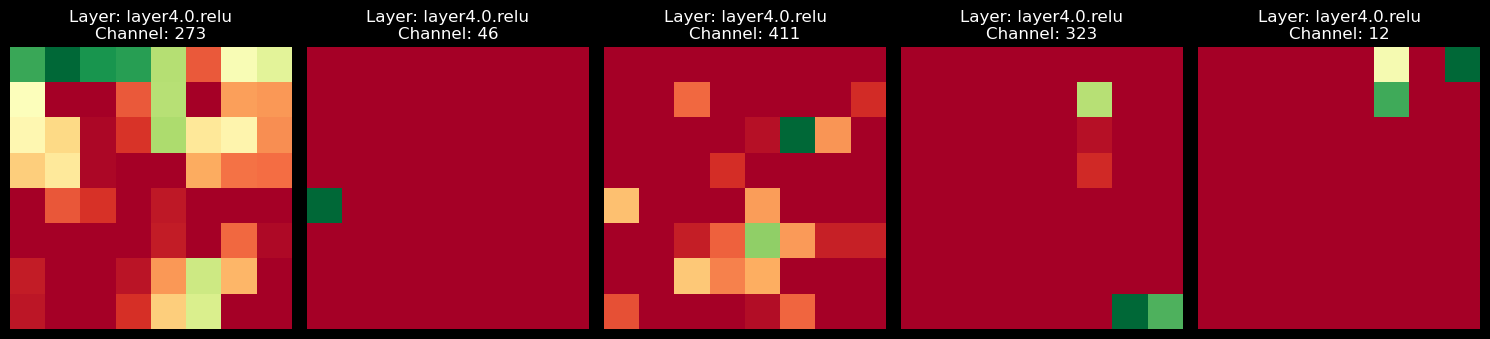

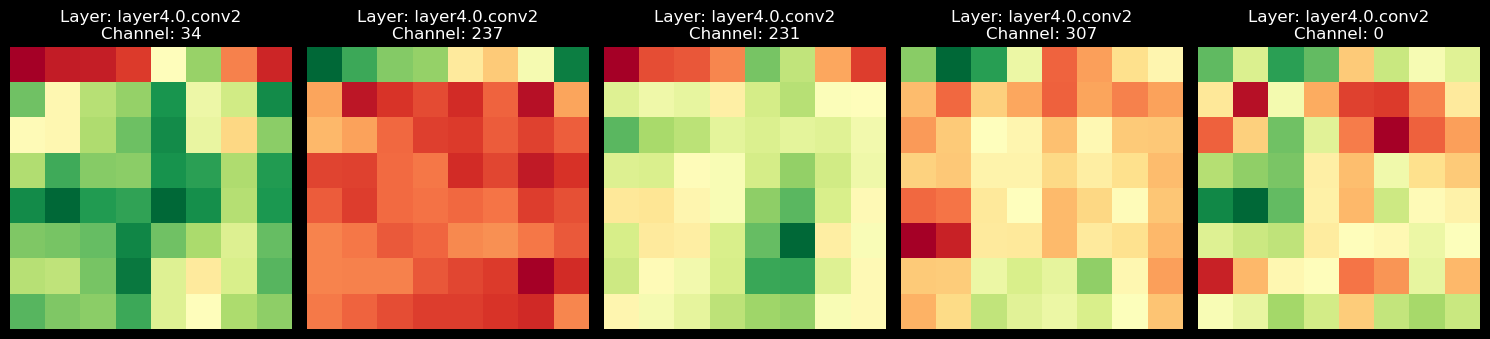

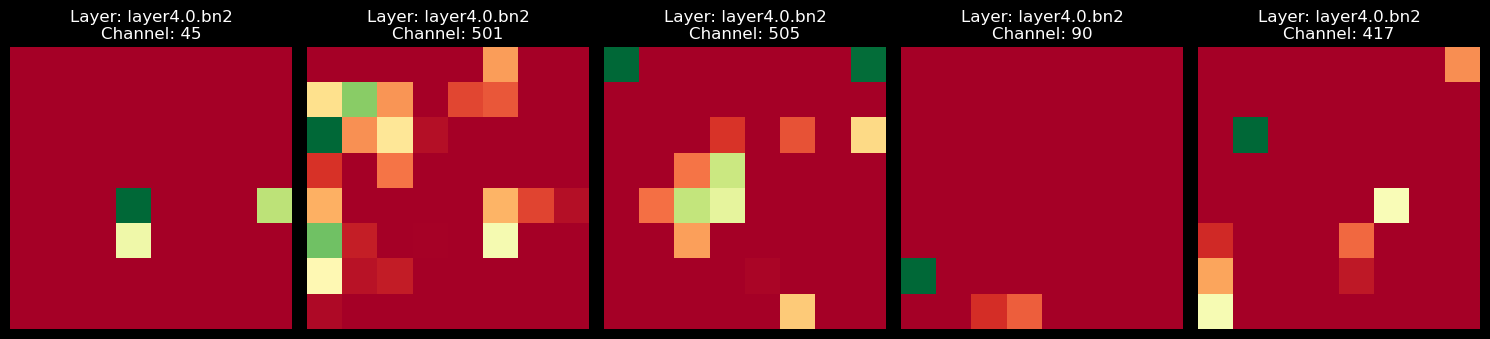

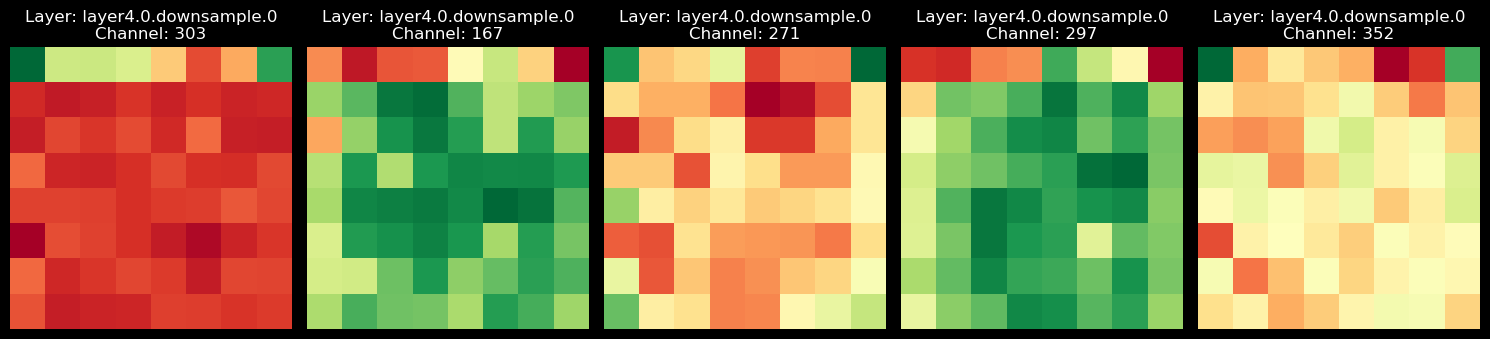

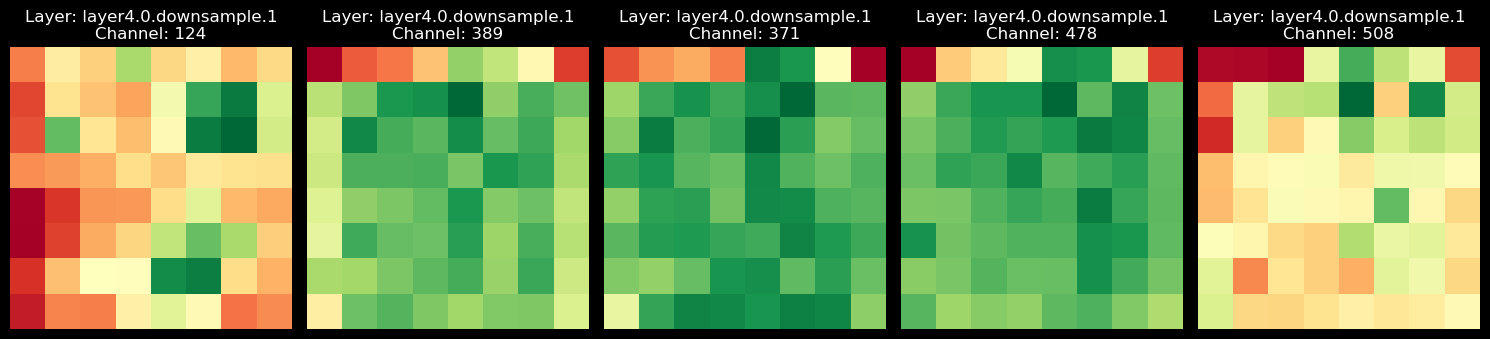

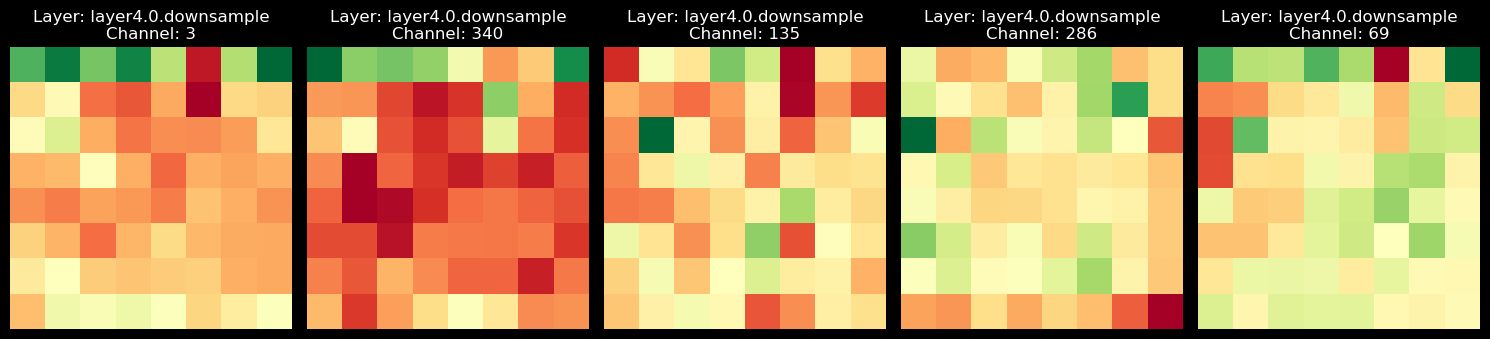

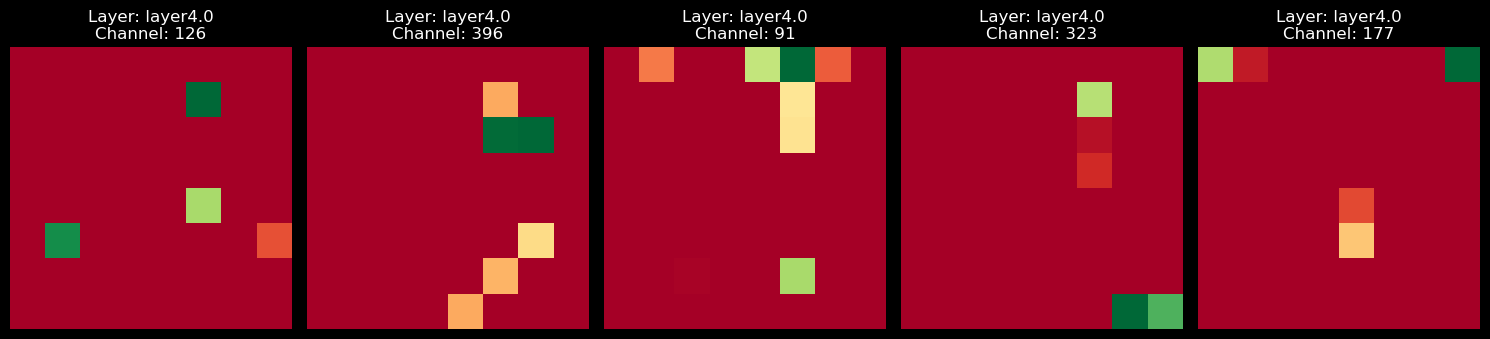

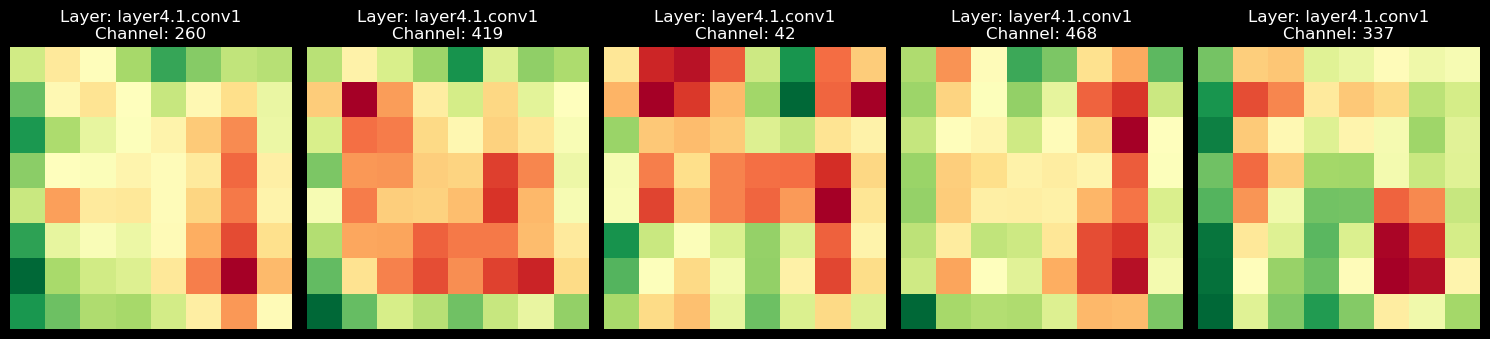

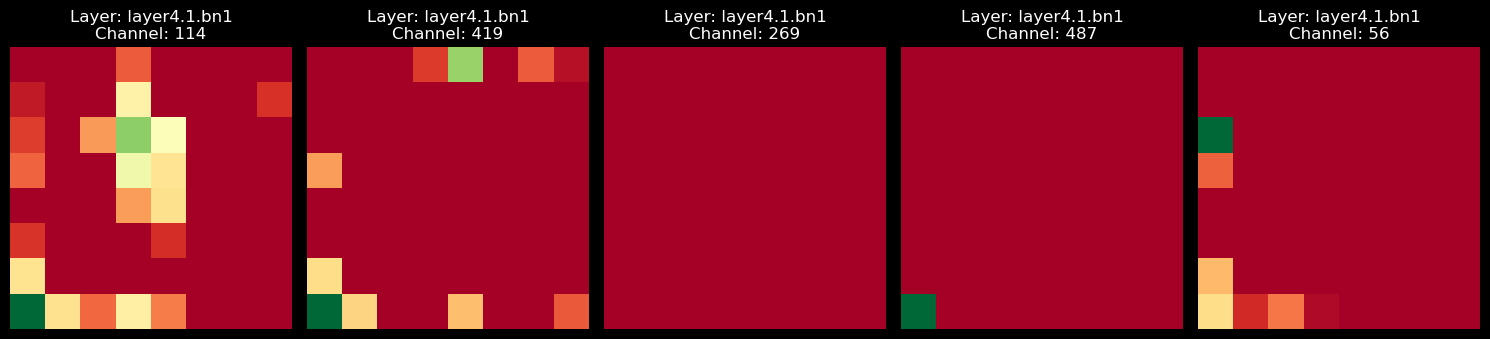

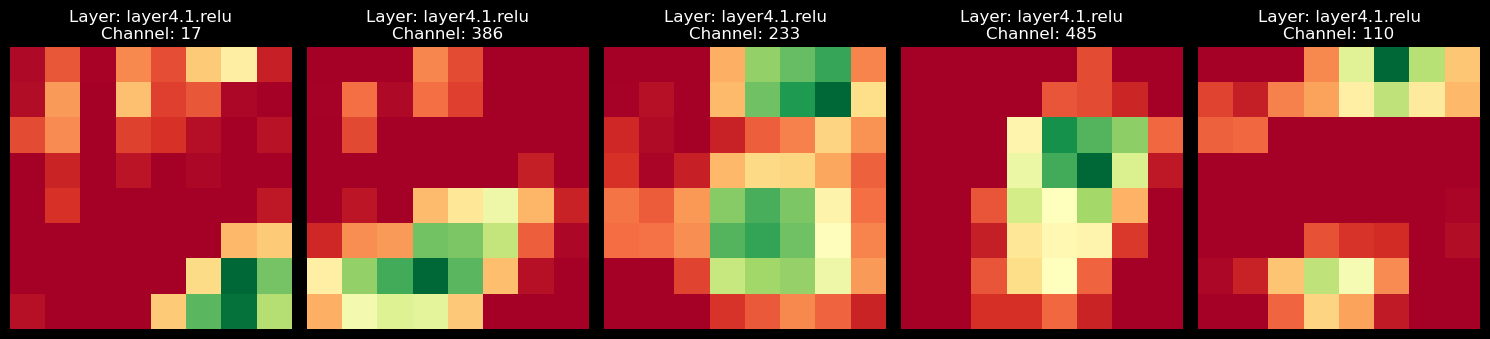

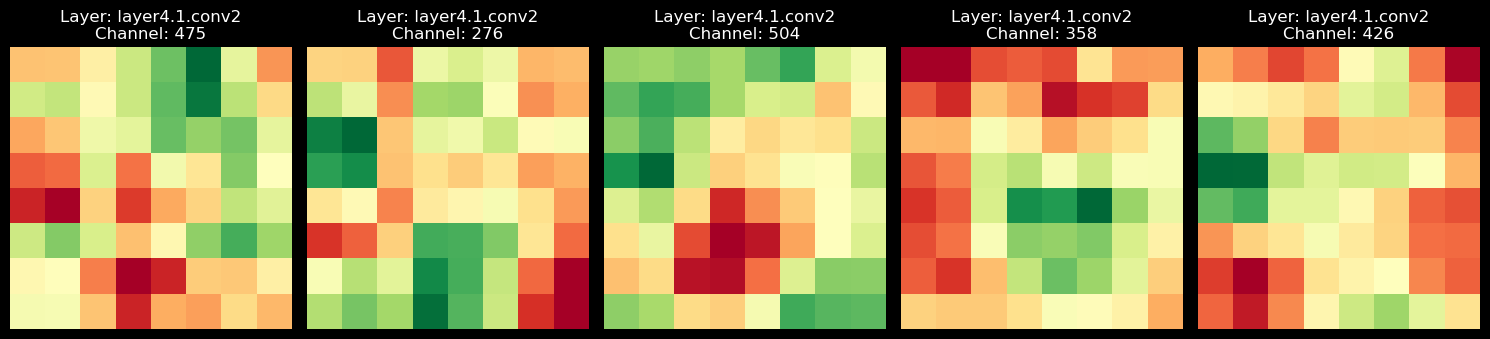

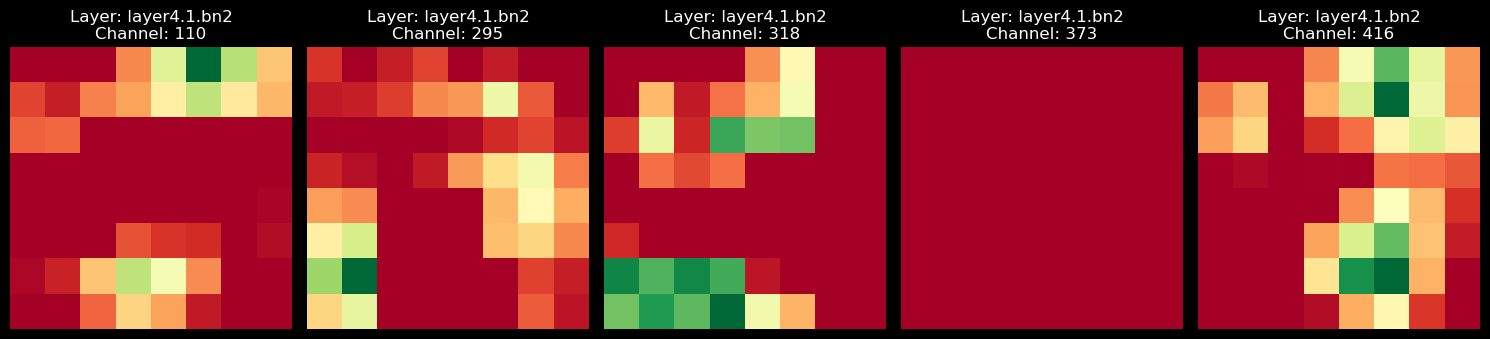

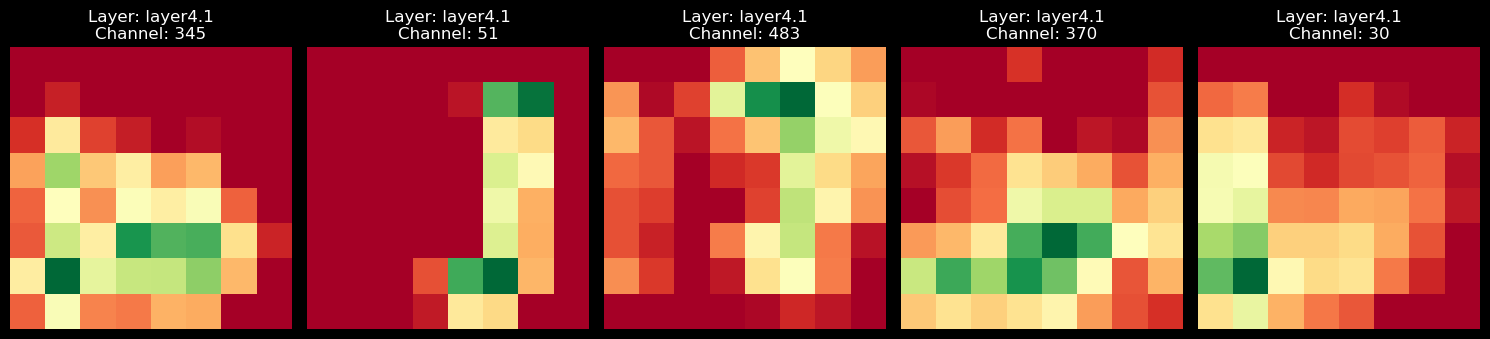

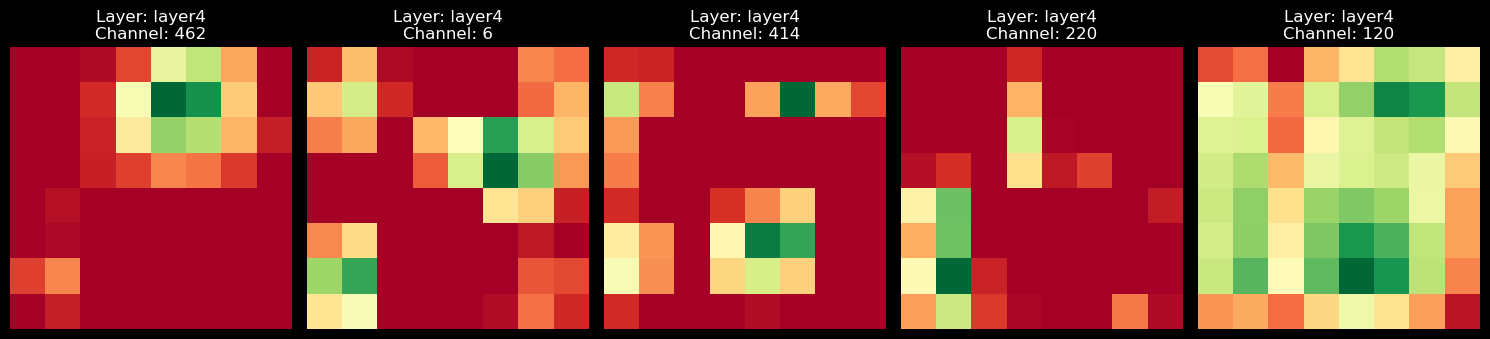

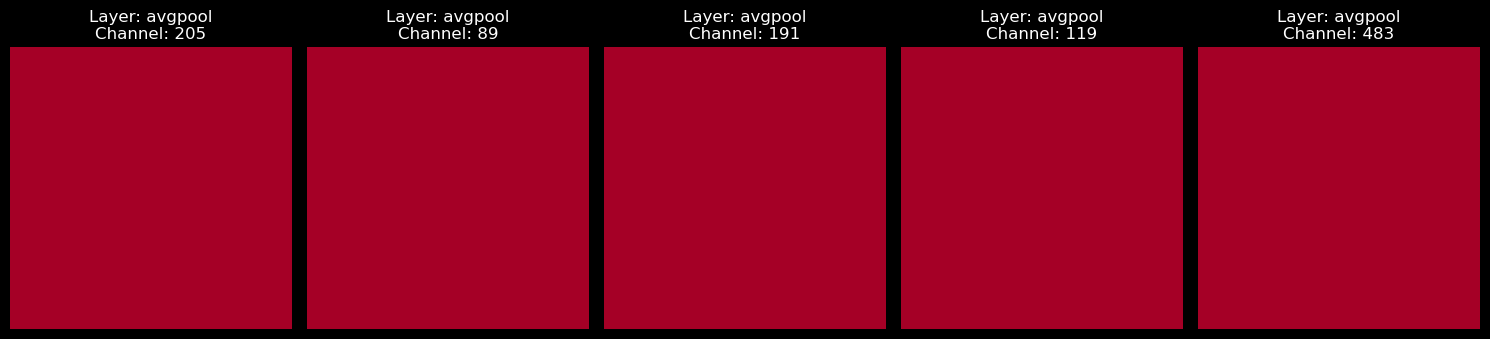

In [9]:
plot_activations(activations, img, num_activations=5)